In [1]:
import ssdeep
import pickle,os,sys,gc
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from tqdm import tqdm
from collections import Counter
import multiprocessing as mp
from multiprocessing import Process, Manager, Pool
import time
from itertools import chain
import math
from operator import itemgetter
from collections import Counter
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage



Bad key "text.kerning_factor" on line 4 in
/home/antslab/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#  import sys,os
print(sys.executable)
print(sys.version)
print(sys.version_info)
import findspark
# os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3' #'/home/antslab/anaconda3/bin/python'
findspark.init()
import pyspark
# from pyspark import SparkContext
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row, SQLContext, SparkSession, window
from pyspark import SparkConf, SparkContext
# Import data types
from pyspark.sql.types import *
import  pyspark.sql.functions as F
conf = SparkConf()
# conf.set("spark.local.dir", "/mnt/ssd240g/data/Leo_Spark_Home/tmp")
conf.set("spark.executor.cores","12")
conf.setMaster("local[12]")
conf.set("spark.driver.memory","85g")
conf.set("spark.executor.memory", "95g")
conf.set("spark.memory.offHeap.enabled","true")
conf.set("spark.memory.offHeap.size","85g")
conf.set("spark.driver.extraJavaOptions","-Xss80g")
conf.set("spark.driver.extraJavaOptions","-Xms80g")
# conf.set("spark.memory.storageFraction","0.2")
# conf.set("spark.driver.maxResultSize","0")
# conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
# conf.set("spark.sql.execution.arrow.enabled", "true")
conf.set("spark.kubernetes.pyspark.pythonVersion","3")
conf.set("spark.sql.shuffle.partitions",100000)
conf.set("spark.driver.maxResultSize", "150g")

# spark = SparkSession.builder.appName("pcap_analyzer").config(conf=conf).getOrCreate() #pcap_analyzer pcapAnalyzer
spark = SparkSession.builder.master("local").appName("Test_spark").config(conf=conf).getOrCreate()
# spark.conf.set("spark.sql.execution.arrow.enabled", True)
spark.conf.set("spark.sql.debug.maxToStringFields", 290000)
spark.conf.set("spark.sql.hive.filesourcePartitionFileCacheSize",100*1024*1024*1024)

import databricks.koalas as ks
ks.options.display.max_rows = 20
ks.set_option('compute.max_rows', None)
# ks.set_option('compute.ops_on_diff_frames', True)
ks.set_option('compute.default_index_type', 'distributed')
print(ks.__version__)
spark.version

/home/antslab/anaconda3/bin/python
3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
0.33.0


'3.0.0-preview2'

In [3]:
in_file = "/home/antslab/123data_hdd4t/pcap_process/pcap_spark/2020_01_11/中華電信/parquet/2020_01_11_session_v7-2_hashpayload_time_size.parquet"
pickle_dir = '/home/antslab/123_pcap_inter/2020_01_11/中華電信/case_pickles/'
picture_dir = '/home/antslab/spark_data/pcap_inter/2020_01_11/中華電信/case_pictures/'
if not os.path.exists(pickle_dir):
    os.makedirs(pickle_dir,exist_ok=True)
if not os.path.exists(picture_dir):
    os.makedirs(picture_dir,exist_ok=True)    
df = ks.read_parquet(in_file)
print(df.columns)
df = df[['session_time','session_time_list','session_duration','session_tt_packet', 'session_i_tt_packet', 'session_o_tt_packet',
             'session_tt_frame_length', 'session_i_tt_frame_length','session_o_tt_frame_length','udp_tt_length', 'udp_i_tt_length',
             'udp_o_tt_length', 'udp_i_avg_length', 'udp_o_avg_length','icmp_i_avg_length', 'icmp_o_avg_length',
             'icmp_tt_original_datagram_length', 'icmp_i_tt_datagram_length','icmp_o_tt_datagram_length', 'icmp_i_avg_datagram_length',
             'icmp_o_avg_datagram_length','tcp_tt_payload_length', 'tcp_i_tt_payload_length','tcp_o_tt_payload_length', 'tcp_i_avg_payload_length',
             'tcp_o_avg_payload_length','ip_src', 'ip_dst','tcp_srcport', 'tcp_dstport', 'udp_srcport', 'udp_dstport', 'country',
             'city', 'subdivisions','domain','isp','frame_i_common_protocols','frame_o_common_protocols', 'frame_i_max_protocols','frame_o_max_protocols', 'tcp_i_payload_list', 'tcp_o_payload_list'        
            ]]
# df['tcp_payload_avg'] = df.tcp_payload_size/df.session_packets
# df['udp_payload_size'] = df.udp_length_sum - (df.session_packets*8)
# df['udp_payload_avg'] = df.udp_payload_size/df.session_packets
# df['icmp_payload_avg'] = df.icmp_length_original_datagram_sum/df.session_packets

 #50461592 
gc.collect()
# df

Index(['session_time', 'session_time_list', 'session_duration',
       'session_tt_packet', 'session_i_tt_packet', 'session_o_tt_packet',
       'session_tt_frame_length', 'session_i_tt_frame_length',
       'session_o_tt_frame_length', 'udp_tt_length', 'udp_i_tt_length',
       'udp_o_tt_length', 'udp_i_avg_length', 'udp_o_avg_length',
       'icmp_tt_length', 'icmp_i_tt_length', 'icmp_o_tt_length',
       'icmp_i_avg_length', 'icmp_o_avg_length',
       'icmp_tt_original_datagram_length', 'icmp_i_tt_datagram_length',
       'icmp_o_tt_datagram_length', 'icmp_i_avg_datagram_length',
       'icmp_o_avg_datagram_length', 'tcp_hdr_len_sum',
       'tcp_tt_payload_length', 'tcp_i_tt_payload_length',
       'tcp_o_tt_payload_length', 'tcp_i_avg_payload_length',
       'tcp_o_avg_payload_length', 'ip_avg_ttl', 'ip_max_ttl',
       'tcp_avg_window', 'tcp_max_window', 'ip_src', 'ip_dst', 'ip_proto',
       'tcp_srcport', 'tcp_dstport', 'udp_srcport', 'udp_dstport', 'country',
       'city', '

563

In [4]:
 #篩選出有in bound payload的session
df1 = df[(df.session_duration>0.1)&(df.session_i_tt_packet>1)&(df.session_i_tt_frame_length>0)&
         (df.tcp_i_payload_list.astype(str)!='[]')]
df1 = df1[(df1.udp_i_tt_length>0)|(df1.udp_i_avg_length>0)|(df1.icmp_i_avg_length>0)|
        (df1.icmp_i_tt_datagram_length>0)|(df1.tcp_i_tt_payload_length>0)|(df1.tcp_i_avg_payload_length>0)]
gc.collect()
# df1

513

In [5]:
df2 = df1[(df1.tcp_o_payload_list.astype(str)!='[]')&(df1.session_o_tt_packet>0)&(df1.session_o_tt_frame_length>0)]
df2 = df2[(df2.udp_o_tt_length>0)|(df2.udp_o_avg_length>0)|(df2.icmp_o_avg_length>0)|
        (df2.icmp_o_tt_datagram_length>0)|(df2.tcp_o_tt_payload_length>0)|(df2.tcp_o_avg_payload_length>0)]
df2 = df2[(df2.domain != 'googlebot.com')|(df2.isp!='Googlebot')]
gc.collect()
df2 = df2.to_pandas()
df2

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,isp,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
0,1.578713e+09,"[1578713142.136986, 1578713142.137222, 1578713...",2.640736,23,12,11,2121,1115,1006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819,455,364,37.916667,33.090909,1.1.247.92,210.242.148.121,50382,445,NaN,NaN,Thailand,Nakhon Ratchasima,Nakhon Ratchasima,totinternet.net,TOT,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcV...,[[6:iCV00dYMe9hNV9oauSf0oa0VfCy/a9evgfey9FV1RG...
1,1.578696e+09,"[1578695986.748107, 1578695986.748734, 1578695...",2.890607,14,6,8,1400,700,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596,364,232,60.666667,29.000000,1.161.141.45,210.242.149.69,52612,445,NaN,NaN,Taiwan,Taipei,Taipei City,hinet.net,HiNet,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[3:11QRfDp03vV1V1Ud2FV1V1V1V1V1V1V1V1V1V1V1V1...,[[3:11QQoW503vV1V1cdcV1V1V1V1V1V1V1V1V1V133FfX...
2,1.578699e+09,"[1578698650.942732, 1578698650.945155, 1578698...",3.191660,8,5,3,726,478,248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270,196,74,39.200000,24.666667,1.162.110.203,210.242.145.102,50489,1433,NaN,NaN,Taiwan,Taipei,Taipei City,hinet.net,HiNet,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:M5YxTvuw3zLwGKeH8UMfDx/fYSKVKiA+Oi56i1J:M...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
3,1.578691e+09,"[1578690933.004252, 1578690933.00447, 15786909...",0.431340,9,5,4,870,488,382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342,194,148,38.800000,37.000000,1.162.110.203,210.242.145.102,51071,1433,NaN,NaN,Taiwan,Taipei,Taipei City,hinet.net,HiNet,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:MdjYxTvuw36I69CxVZE3CQDaht42IvimQA+Oi56i1...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
4,1.578690e+09,"[1578689993.695778, 1578689993.696081, 1578689...",2.316350,9,5,4,870,488,382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342,194,148,38.800000,37.000000,1.162.110.203,210.242.145.102,52688,1433,NaN,NaN,Taiwan,Taipei,Taipei City,hinet.net,HiNet,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:MdjYxTvuw36Inq1Vqx2BICHV5S96OmZA+Oi56i1J:...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850403545100,1.578709e+09,"[1578709169.06663, 1578709169.066773, 15787091...",121.960976,18,8,10,1628,808,820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596,364,232,45.500000,23.200000,95.59.142.98,210.242.149.122,65398,445,NaN,NaN,Kazakhstan,Nur-Sultan,Nur-Sultan,None,JSC Kazakhtelecom,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[3:11QRfDp03vV1V1Ud2FV1V1V1V1V1V1V1V1V1V1V1V1...,[[3:11QQoW503vV1V1cdcV1V1V1V1V1V1V1V1V1V133FfX...
850403545101,1.578675e+09,"[1578674715.40572, 1578674715.405952, 15786747...",21.684397,70,46,24,62503,17471,45032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58119,14679,43440,319.108

In [6]:
print(df2.domain.value_counts().head(60))
df2.isp.value_counts().head(60)

hinet.net                        725834
viettel.vn                        40860
linkone.co.kr                     38036
cantv.net                         37828
vnpt.vn                           15910
telecomitalia.it                  15837
ip-193-70-6.eu                    10980
linode.com                        10407
ip-94-23-145.eu                   10178
stationtelecom.com.br              6429
magticom.ge                        5356
ip-51-91-212.eu                    4588
actcorp.in                         4087
prod-infinitum.com.mx              3754
gov.co                             3722
digicable.sk                       3388
comcastbusiness.net                3051
telkom.net.id                      2848
no-reverse-dns-configured.com      2847
pldt.net                           2753
ip-5-135-73.eu                     2744
ip-139-99-113.net                  2705
uninet-ide.com.mx                  2444
tedata.net                         2197
totinternet.net                    2149


HiNet                                              727572
China Telecom                                       98564
tseot.cn                                            93861
Directweb Tecnologia em Informatica Eireli          89895
OVH SAS                                             79954
Viettel Corporation                                 78621
Sudatel                                             68861
System Net Ltd                                      50761
Viettel Group                                       50322
Converge                                            45966
Sejong Telecom                                      38929
Cantv                                               38845
Hostkey B.v.                                        29661
Tencent cloud computing                             23801
Digital Ocean                                       23211
Perviy TSOD LLC                                     19342
VNPT                                                19021
LLC Cloud Netw

In [7]:
# case protocol study
ip_li = ['5.188.211.35','5.188.210.65','213.87.148.112','172.80.253.50','203.150.154.191',
         '149.129.50.37','106.12.69.27','109.169.21.204','195.154.200.161','94.23.20.187',
         '200.255.122.170','173.82.105.53']
for ip in ip_li:
    print(ip,':',df[df.ip_src == ip].frame_i_max_protocols.unique().to_numpy())

5.188.211.35 : [None 'eth:ethertype:ip:tcp:http'
 'eth:ethertype:ip:tcp:http:urlencoded-form' 'eth:ethertype:ip:tcp']
5.188.210.65 : []
213.87.148.112 : []
172.80.253.50 : ['eth:ethertype:ip:icmp:data' 'eth:ethertype:ip:tcp:http:urlencoded-form'
 'eth:ethertype:ip:tcp:http:data' 'eth:ethertype:ip:tcp']
203.150.154.191 : ['eth:ethertype:ip:tcp']
149.129.50.37 : ['eth:ethertype:ip:tcp:http' 'eth:ethertype:ip:tcp']
106.12.69.27 : ['eth:ethertype:ip:tcp:http' 'eth:ethertype:ip:tcp:http:data'
 'eth:ethertype:ip:tcp' 'eth:ethertype:ip:tcp:http:urlencoded-form:data']
109.169.21.204 : ['eth:ethertype:ip:tcp:http:data' 'eth:ethertype:ip:tcp']
195.154.200.161 : ['eth:ethertype:ip:tcp']
94.23.20.187 : ['eth:ethertype:ip:tcp:ftp' 'eth:ethertype:ip:tcp']
200.255.122.170 : ['eth:ethertype:ip:tcp:http:urlencoded-form'
 'eth:ethertype:ip:tcp:http:data' 'eth:ethertype:ip:tcp']
173.82.105.53 : ['eth:ethertype:ip:tcp:http:urlencoded-form']


In [36]:
case_df = df2[(df2.ip_src == '106.12.69.27')&(df2.frame_i_max_protocols.str.contains('http'))]
time_li = case_df.session_time_list.tolist()
time_li = [list(x) for x in time_li]
pickle.dump(obj=time_li,file=open(pickle_dir+"106.12.69.27_timelist_http.pkl",'wb'))
print(len(time_li))
case_df

14


,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,isp,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
17179880083,1.578702e+09,"[1578701943.722055, 1578701943.722563, 1578701...",4.378388,11,6,5,1337,553,784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,619,173,446,28.833333,89.200000,106.12.69.27,210.242.148.97,38226,80,NaN,NaN,China,Shanghai,Shanghai,None,Beijing Baidu Netcom Science and Technology Co.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines:xml,[[12:GdBr7TspQifuPRCk4XIWpNECO4XIWpNECR72sNEYi...,"[[3:KD+U/kIgfFf+S5aPS:KKAk7flea, 1578701948.01..."
60129552632,1.578720e+09,"[1578720020.637983, 1578720020.638245, 1578720...",13.184245,14,7,7,2065,1112,953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1101,654,447,93.428571,63.857143,106.12.69.27,210.242.147.10,39344,80,NaN,NaN,China,Shanghai,Shanghai,None,Beijing Baidu Netcom Science and Technology Co.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form:data,eth:ethertype:ip:tcp:http:data-text-lines:data,[[48:3ZW8aKu185yqiY18R475SrZWT1+e5VjhjjhX3R:bu...,[[24:KPfcE7SadNCYb5miImFQh4b7Q2gZX82+L7H6EN6H:...
85899346344,1.578700e+09,"[1578700488.76919, 1578700488.769344, 15787004...",1.814862,11,6,5,1316,532,784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,598,152,446,25.333333,89.200000,106.12.69.27,210.242.146.127,39752,80,NaN,NaN,China,Shanghai,Shanghai,None,Beijing Baidu Netcom Science and Technology Co.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines:xml,[[12:GFh4FZInk4XIWpNECO4XIWpNECR72sNEYi/sNuHXq...,"[[3:KD+U/kIgfFf+S5aPS:KKAk7flea, 1578700490.50..."
206158430685,1.578684e+09,"[1578684490.083584, 1578684490.083778, 1578684...",0.621763,14,8,6,15576,692,14884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14684,204,14480,25.500000,2413.333333,106.12.69.27,210.242.148.135,49464,80,NaN,NaN,China,Shanghai,Shanghai,None,Beijing Baidu Netcom Science and Technology Co.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data,eth:ethertype:ip:tcp:http:data-text-lines,[[12:TqIHXqocuDWk4XIWpNECO4XIWpNECR72sNEYi/sNu...,[[96:b/vb4HCp4QuQxr9AjqozJnsnSnrnb0cRUXYt3mZiH...
240518169022,1.578684e+09,"[1578683946.476057, 1578683946.476326, 1578683...",11.892976,11,6,5,947,543,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229,163,66,27.166667,13.200000,106.12.69.27,210.242.145.177,53398,80,NaN,NaN,China,Shanghai,Shanghai,None,Beijing Baidu Netcom Science and Technology Co.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http,[[12:7KqL7TsTXf+4Ae5k4XIWpNECO4XIWpNECR72sNEYi...,[[6:KKA7fXXX7Uj+SVXTBHE7RWf6Q9ZTR66T7Dhmn:KX7f...
240518179128,1.578688e+09,"[1578688327.761798, 1578688327.761971, 1578688...",0.446058,10,5,5,1248,464,784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596,150,446,30.000000,89.200000,106.12.69.27,210.242.145.118,41906,80,NaN,NaN,China,Shanghai,Shanghai,None,Beijing Baidu Netcom Science and Technology Co.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines:xml,[[12:GZsvDYX68k4XIWpNECO4XIWpNECR72sNEYi/sNuHX...,"[[3:KD+U/kIgfFf+S5aPS:KKAk7flea, 1578688328.07..."
300647721578,1.578742e+09,"[1578742394.981588, 15787

### Function

In [33]:
 
def prepare_df(df2,protocol_name='http',split="size",loner=False):
    protocol_name = str(protocol_name).lower()
    '''
    df2: filterout no payload's all sessions df
    protocol_name: what TCP protocol string would be contained e.g., smb,http,tds...
    
    return1: protocol original dataframe (session-based)
    return2: protocol payload dataframe (packet-based)
    '''
    def sort_fn(data):
        '''
        sort by time: itemgetter(1)
        sort by size: itemgetter(2)
        '''
        if split=='size':
            return sorted(data,key=itemgetter(2))
        elif split == 'time':
            return sorted(data,key=itemgetter(1))
                    
    def split_col_len(session):
        '''
        input: list(session) of lists(packets) =>tuple=(hash,time)

        Return1: list of ssdeep length
        Return2: list of session's packets hashes
        '''
    #     for session in payload_li:
#         packet_payload = []
        packet_len = []
        for packet in session:
            ssdeep_hash = packet[0]
    #         packet_payload.append(ssdeep_hash)
            packet_len.append(ssdeep_hash.split(':')[0])
        return packet_len#,packet_payload

    def split_col_hash(session):
        '''
        input: list(session) of lists(packets) =>tuple=(hash,time)

        Return1: list of ssdeep length
        Return2: list of session's packets hashes
        '''
    #     for session in payload_li:
        packet_payload = []
#         packet_len = []
        for packet in session:
            ssdeep_hash = packet[0]
            packet_payload.append(ssdeep_hash)
    #         packet_len.append(ssdeep_hash.split(':')[0])
        return packet_payload
    if not loner:
        df2_protocol = df2[(df2.frame_i_max_protocols.str.contains(protocol_name))&(df2.frame_o_max_protocols.str.contains(protocol_name))]
    else:
        df2_protocol = df2
    df2_protocol_payload = df2_protocol[['tcp_i_payload_list']]
    df2_protocol_payload['tcp_i_payload_list'] = df2_protocol_payload.tcp_i_payload_list.map(sort_fn)
    df2_protocol_payload['size'] = df2_protocol_payload.tcp_i_payload_list.map(split_col_len) #,df2_protocol_payload['hash']
    df2_protocol_payload['hash'] = df2_protocol_payload.tcp_i_payload_list.map(split_col_hash)
    L_size = [x if isinstance(x, list) else [x] for x in df2_protocol_payload['size']]
    L_hash = [x if isinstance(x, list) else [x] for x in df2_protocol_payload['hash']]
    df2_protocol_payload = pd.DataFrame({
        'idx':df2_protocol_payload.index.values.repeat([len(x) for x in L_size]),
        'size':list(chain.from_iterable(L_size)),
        'hash':list(chain.from_iterable(L_hash))
        })
    # df2_protocol_payload['idx'] = 
    df2_protocol_payload['size'] = df2_protocol_payload['size'].astype(int)
    if not loner:
        return df2_protocol, df2_protocol_payload
    else:
        return df2_protocol_payload

In [55]:
def similarity_compare(df2_protocol,df2_protocol_payload,ori_protocol=None,ori_protocol_payload=None,thr=0,thr2=10,loner=False): #40
    '''
    GOAL: compare with timestamp's q1,q2,q3 to similar size packet. Pick max value for score.
    df2_protocol: protocol original dataframe (session-based)
    df2_protocol_payload: protocol payload dataframe (packet-based)
    loner:需指派ori_protocol、ori_protocol_payload
    
    Return: dictionary with each cluster 
    '''
    def ssdeep_compare(target_hash,candidate_df):
        '''
        Input1: string of hash
        Input2: dataframe of candidate
        '''
        def compare(candidate_hash):
            return ssdeep.compare(target_hash,candidate_hash)
        return candidate_df.hash.map(compare)
    big_dict_protocol = {}
    big_dict_protocol_score = {}
#     big_dict_protocol2 = {} #test
    used_idx_li = []
    all_scores = [] #test2
    for idx in tqdm(df2_protocol.index):
        if idx in used_idx_li:
            continue
        target = df2_protocol_payload[df2_protocol_payload.idx == idx]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q1 = int(t_len*0.25)
        q2 = int(t_len*0.5)
        t_q1 = target.iloc[q1,-1]
        if not loner:
            candidate = df2_protocol_payload[df2_protocol_payload.idx!=idx]
            candidate = candidate[~candidate.idx.isin(used_idx_li)] #candidat不可重複分群
        else:
            t_ip = df2_protocol[df2_protocol.index == idx].ip_src.values[0]
            candidate_idx = ori_protocol[ori_protocol.ip_src == t_ip].index.tolist()
            candidate = ori_protocol_payload[ori_protocol_payload.idx.isin(candidate_idx)] #可重複分群?
        
        candidate['idx'] = candidate.idx.astype(str)
#         candidate_q1 = candidate[candidate['size']==target.iloc[q1,-2]] #rule
        candidate['q1'] = ssdeep_compare(t_q1,candidate) #rule:candidate_q1
        if q2 != q1:
            t_q2 = target.iloc[q2,-1]
            q3 = int(t_len*0.75)
#             candidate_q2 = candidate[candidate['size']==target.iloc[q2,-2]] #rule
            candidate['q2'] = ssdeep_compare(t_q2,candidate) #rule:candidate_q2
            if q3 != q2:
                t_q3 = target.iloc[q3,-1]
#                 candidate_q3 = candidate[candidate['size']==target.iloc[q3,-2]] #rule
                candidate['q3'] = ssdeep_compare(t_q3,candidate) #rule:candidate_q3
                if t_len>4:
#                     t_min = target.iloc[0,-1] 
#                     candidate['min'] = ssdeep_compare(t_min,candidate)
                    t_max = target.iloc[-1,-1]
                    candidate['max'] = ssdeep_compare(t_max,candidate)
                    
        candidate = candidate.drop(['size','hash'],axis=1)
        candidate['score'] = candidate.mean(axis=1) #max
        score_li = candidate.score.tolist() #test2
        candidate = candidate[candidate.score>thr] #相似度分數，數字越小速度愈快、數字越大越多群
        candidate['idx'] = candidate.idx.astype(int)
#         candidate2 = candidate[candidate.score<thr2] #test
        idx_li = list(set(candidate.idx.tolist()))
#         idx_li2 = list(set(candidate2.idx.tolist())) #test
        all_scores.extend(score_li) #test2
        if len(idx_li)>0:
            
            used_idx_li.extend(idx_li)
            used_idx_li.append(idx)
            if not loner:
                big_dict_protocol[idx] = idx_li
                big_dict_protocol_score[idx] = candidate.score.tolist()
            else:
                big_dict_protocol[t_ip+'_'+str(idx)] = idx_li
                big_dict_protocol_score[t_ip+'_'+str(idx)] = candidate.score.tolist()                
#         if len(idx_li2)>0: #test
#             big_dict_protocol2[idx] = idx_li2 # test
    return big_dict_protocol,sorted(list(set(df2_protocol.index)-set(used_idx_li))),all_scores,big_dict_protocol_score #test

In [10]:
def write2pkl(df2_protocol,big_dict,cluster_key,case_id,path=pickle_dir):
    '''
    GOAL: output 3-tuple to draw time diagram
    df2_protocol: original dataframe session-based
    big_dict: big_dict_protocol
    cluster_key: print by find_cluster function
    case_id: user defined to identify
    '''
    cluster_key = int(cluster_key)
#     print(big_dict[cluster_key])
    temp_li = big_dict[cluster_key][:]
#     print(temp_li)
    temp_li.append(cluster_key) #最後一個session才是key (target)，其他人(candidates)都是跟他(target)比
#     print(temp_li)
#     temp_li = temp_li2[:]
    case_diagram = df2_protocol.loc[list(set(temp_li))]
    time_lists = case_diagram.session_time_list.tolist()
    time_lists = [list(x) for x in time_lists]
    ips = case_diagram.ip_src.tolist()
    countries = case_diagram.country.tolist()
    print('Unique Country#:',len(set(countries)),"Unique IP#:",len(set(ips)),'Session#:',len(time_lists))
    # pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
    pickle.dump(obj=(time_lists,ips,countries),file=open(path+'case#'+str(case_id)+'_threetuples.pkl','wb'))        


In [11]:
def find_cluster(big_dict,idx):
    '''
    big_dict: big_dict_protocol
    idx: which idx want to find
    Return cluster id (big_dict"s key number')
    '''
    idx = int(idx)
    try:
        big_dict[idx] #KeyError
        return idx
    except KeyError:
        for k,v in big_dict.items():
            if idx in v:
                return k
                break

In [12]:
def cluster_stat(protocol_big_dict,protocol_df,drawlog=False):
    """
    GOAL: output statistic of certain protocol
    input1: dict from similarity_compare
    inpit2: df from prepare_df
    """
    
    all_nums = []
    clus_id = []
    # all_num = 0
    for k,v in protocol_big_dict.items():
    #     all_nums.extend(v)
        all_nums.append(len(v))
        clus_id.append(k)
    #     all_num +=len(v)
    clus_num = len(all_nums)
    print("原本總共sessions#:",len(protocol_df))
    print("共有#sessions可分群:",sum(all_nums)+clus_num,"共有#lonerSessions:",len(protocol_df)-(sum(all_nums)+clus_num))
    print("可分為#群:",clus_num)
#     print(sum(all_nums)+len(all_nums),len(protocol_df)-(sum(all_nums)+len(all_nums)),len(protocol_df))
    protocol_stat_df = pd.DataFrame(all_nums,index=clus_id)
    protocol_stat_df[0] = protocol_stat_df[0]+1
    print("前三大的cluster key與對應之群集大小\n",protocol_stat_df[0].nlargest(5))
    print(protocol_stat_df.describe())
    if drawlog:
        fig, ax = plt.subplots()
        protocol_stat_df.hist(ax=ax, bins=100, bottom=0.1)
        ax.set_yscale('log')
    else:
        protocol_stat_df.hist(bins=50)

In [19]:
def cluster_rep_hash(proto_big_dict,proto_df_payload,proto_df,date='0110',protocol='http'):
    '''
    GOAL: create each cluster's representaion ssdeep hash
    proto_df_payload: from prepare_df() function
    proto_big_dict: from similarity_compare() function
    date & protocol: user_defined cluster name
    
    Return: dict[cluster_name]: ssdeep hash
    '''
    upgma_dict = {}
    for key in proto_big_dict.keys():
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        q2_hash = target.iloc[q2,-1]
        country = proto_df.loc[key,'country']
        ip = proto_df.loc[key,'ip_src']
        domain = proto_df.loc[key,'domain']
        upgma_dict[str(protocol)+'_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
    return upgma_dict



def pair_wise_score(upgma_dict):
    '''
    GOAL: calculate distance matrix by calculating paire-wise similarity score. 
    and pick upper triangle convert to list
    Input: from cluster_rep_hash() function
    ['cluster']: name
    ['ssdeep']: cluster's representation hash
    
    Return: df=>['c_ssdeep_li']:the hashes list compare to, ['score']:list of distances (upper-triangle, exclude self)
    '''
    def compare(target_hash,candidate_hash_li):
        score_li = []
        for c_hash in candidate_hash_li:
            score_li.append(100-ssdeep.compare(target_hash,c_hash)) #相似度滿分100，轉換成距離最近0
        return score_li
    used_idx = []
    def create_hash_li(t_hash):
        idx_set = set(upgma_df[upgma_df.ssdeep == t_hash].index)#[0]
        same_hash_li = sorted(list(idx_set - set(used_idx)))
        idx = same_hash_li[0]
        used_idx.append(idx)
        return upgma_df.loc[idx+1:]['ssdeep'].tolist()
    upgma_df = pd.DataFrame(upgma_dict.items(),columns=['cluster','ssdeep'])
    upgma_df['c_ssdeep_li'] = upgma_df.ssdeep.map(create_hash_li)
    upgma_df['score'] = upgma_df.apply(lambda x: compare(x.ssdeep, x.c_ssdeep_li), axis=1)
    return upgma_df



def draw_upgma(upgma_df,name='upgma'):
    '''
    GOAL: using upper triangle's distance to draw upgma
    Input: from pair_wise_score() function
    Output: diagram of UPGMA
    '''
    score_li = upgma_df['score'].tolist()
    score_li = list(filter(None, score_li))
    score_li = sum(score_li,[])
    Z = linkage(score_li, 'average')
    fig = plt.figure(figsize=(55, 22)) #(25,10)
    # plt.savefig(fig)
    dn = dendrogram(Z,labels=upgma_df.cluster.tolist())
    plt.savefig(picture_dir+str(name)+'.png', dpi=600, format='png', bbox_inches='tight')
    return dn

In [14]:
def case_cluster_info(protocol_loners,protocol_big_dict,protocol_df,proto='http',df2=df2):
    '''
    GOAL: output loner & each cluster's three tuples pickles.
    save file in pickle_dir+protol/ dir
    
    protocol_loners: from similarity_compare() func.
    protocol_big_dict: from similarity_compare() func.
    proto: now using what kind of protocol
    df2: payload whole df
    '''
    loner_df = df2.loc[protocol_loners]
    time_lists = loner_df.session_time_list.tolist()
    time_lists = [list(x) for x in time_lists]
    ips = loner_df.ip_src.tolist()
    countries = loner_df.country.tolist()
    pkl_dir = pickle_dir+proto+'/'
    if not os.path.exists(pkl_dir):
        os.makedirs(pkl_dir)
    pickle.dump(obj=(time_lists,ips,countries),file=open(pkl_dir+'case#loners'+'_threetuples.pkl','wb'))
    #cluster
    protocol_big_dict = {k: v for k, v in sorted(protocol_big_dict.items(), key=lambda item: len(item[1]),reverse=True)}
    for i,k in enumerate(protocol_big_dict.keys()):
        write2pkl(protocol_df,protocol_big_dict,k,str(i+1)+"_"+str(k),path=pkl_dir)
    return protocol_big_dict

http

In [15]:
http_df, http_df_payload = prepare_df(df2,'http')
http_big_dict,http_loners,http_score = similarity_compare(http_df,http_df_payload,thr=0)
gc.collect() #05:38

/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

383

原本總共sessions#: 97875
共有#sessions可分群: 97841 共有#lonerSessions: 34
可分為#群: 132
前三大的cluster key與對應之群集大小
 394    27248
423    15167
554    12969
454    11359
347     4408
Name: 0, dtype: int64
                  0
count    132.000000
mean     741.219697
std     3114.596847
min        2.000000
25%        4.000000
50%        9.000000
75%       73.000000
max    27248.000000


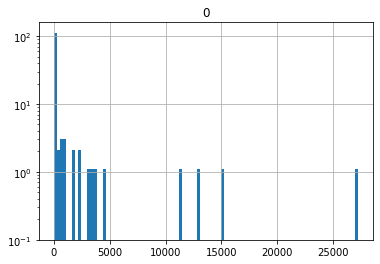

In [16]:

cluster_stat(http_big_dict,http_df,drawlog=True)

                  0
count  1.935454e+06
mean   4.280607e+00
std    1.667034e+01
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    1.000000e+02


{100.0: 10760,
 99.0: 416,
 97.0: 1647,
 96.0: 2020,
 94.0: 3508,
 93.0: 2913,
 91.0: 2488,
 90.0: 1158,
 88.5: 2,
 88.0: 1571,
 86.5: 2,
 86.0: 883,
 85.0: 623,
 83.0: 1081,
 82.0: 2005,
 80.0: 2808,
 79.0: 2145,
 77.0: 1699,
 75.0: 3642,
 74.0: 2891,
 72.0: 1793,
 71.0: 1602,
 69.0: 3427,
 68.0: 3686,
 66.0: 4617,
 65.0: 2192,
 63.0: 2046,
 62.5: 1,
 61.0: 2978,
 60.0: 2244,
 58.0: 2185,
 57.0: 1878,
 56.0: 1,
 55.0: 1564,
 54.0: 1939,
 52.0: 2080,
 50.0: 3686,
 49.0: 2021,
 47.0: 1881,
 46.0: 2428,
 44.0: 1187,
 43.5: 2,
 43.0: 1484,
 42.0: 7,
 41.5: 3,
 41.0: 3019,
 40.0: 3217,
 39.666666666666664: 4,
 39.5: 4,
 39.333333333333336: 2,
 39.0: 4,
 38.666666666666664: 1,
 38.5: 1,
 38.333333333333336: 8,
 38.0: 4739,
 37.666666666666664: 1,
 37.5: 2,
 37.333333333333336: 6,
 37.0: 2,
 36.666666666666664: 5,
 36.333333333333336: 10,
 36.0: 8465,
 35.666666666666664: 5,
 35.333333333333336: 10,
 35.0: 6181,
 34.666666666666664: 6,
 34.5: 1,
 34.333333333333336: 5,
 34.0: 12,
 33.6666666

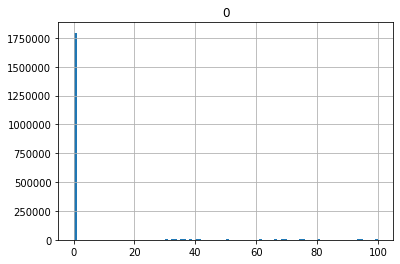

In [17]:
temp = pd.DataFrame(http_score)
temp.hist(bins=100)
print(temp.describe())
temp = dict(Counter(http_score))
{k: v for k, v in sorted(temp.items(), key=lambda item: item[0],reverse=True)}

{'icoord': [[1305.0, 1305.0, 1315.0, 1315.0],
  [1295.0, 1295.0, 1310.0, 1310.0],
  [1285.0, 1285.0, 1302.5, 1302.5],
  [1275.0, 1275.0, 1293.75, 1293.75],
  [1265.0, 1265.0, 1284.375, 1284.375],
  [1255.0, 1255.0, 1274.6875, 1274.6875],
  [1245.0, 1245.0, 1264.84375, 1264.84375],
  [1235.0, 1235.0, 1254.921875, 1254.921875],
  [1225.0, 1225.0, 1244.9609375, 1244.9609375],
  [1215.0, 1215.0, 1234.98046875, 1234.98046875],
  [1205.0, 1205.0, 1224.990234375, 1224.990234375],
  [1195.0, 1195.0, 1214.9951171875, 1214.9951171875],
  [1185.0, 1185.0, 1204.99755859375, 1204.99755859375],
  [1175.0, 1175.0, 1194.998779296875, 1194.998779296875],
  [1165.0, 1165.0, 1184.9993896484375, 1184.9993896484375],
  [1155.0, 1155.0, 1174.9996948242188, 1174.9996948242188],
  [1145.0, 1145.0, 1164.9998474121094, 1164.9998474121094],
  [1135.0, 1135.0, 1154.9999237060547, 1154.9999237060547],
  [1125.0, 1125.0, 1144.9999618530273, 1144.9999618530273],
  [1115.0, 1115.0, 1134.9999809265137, 1134.9999809265

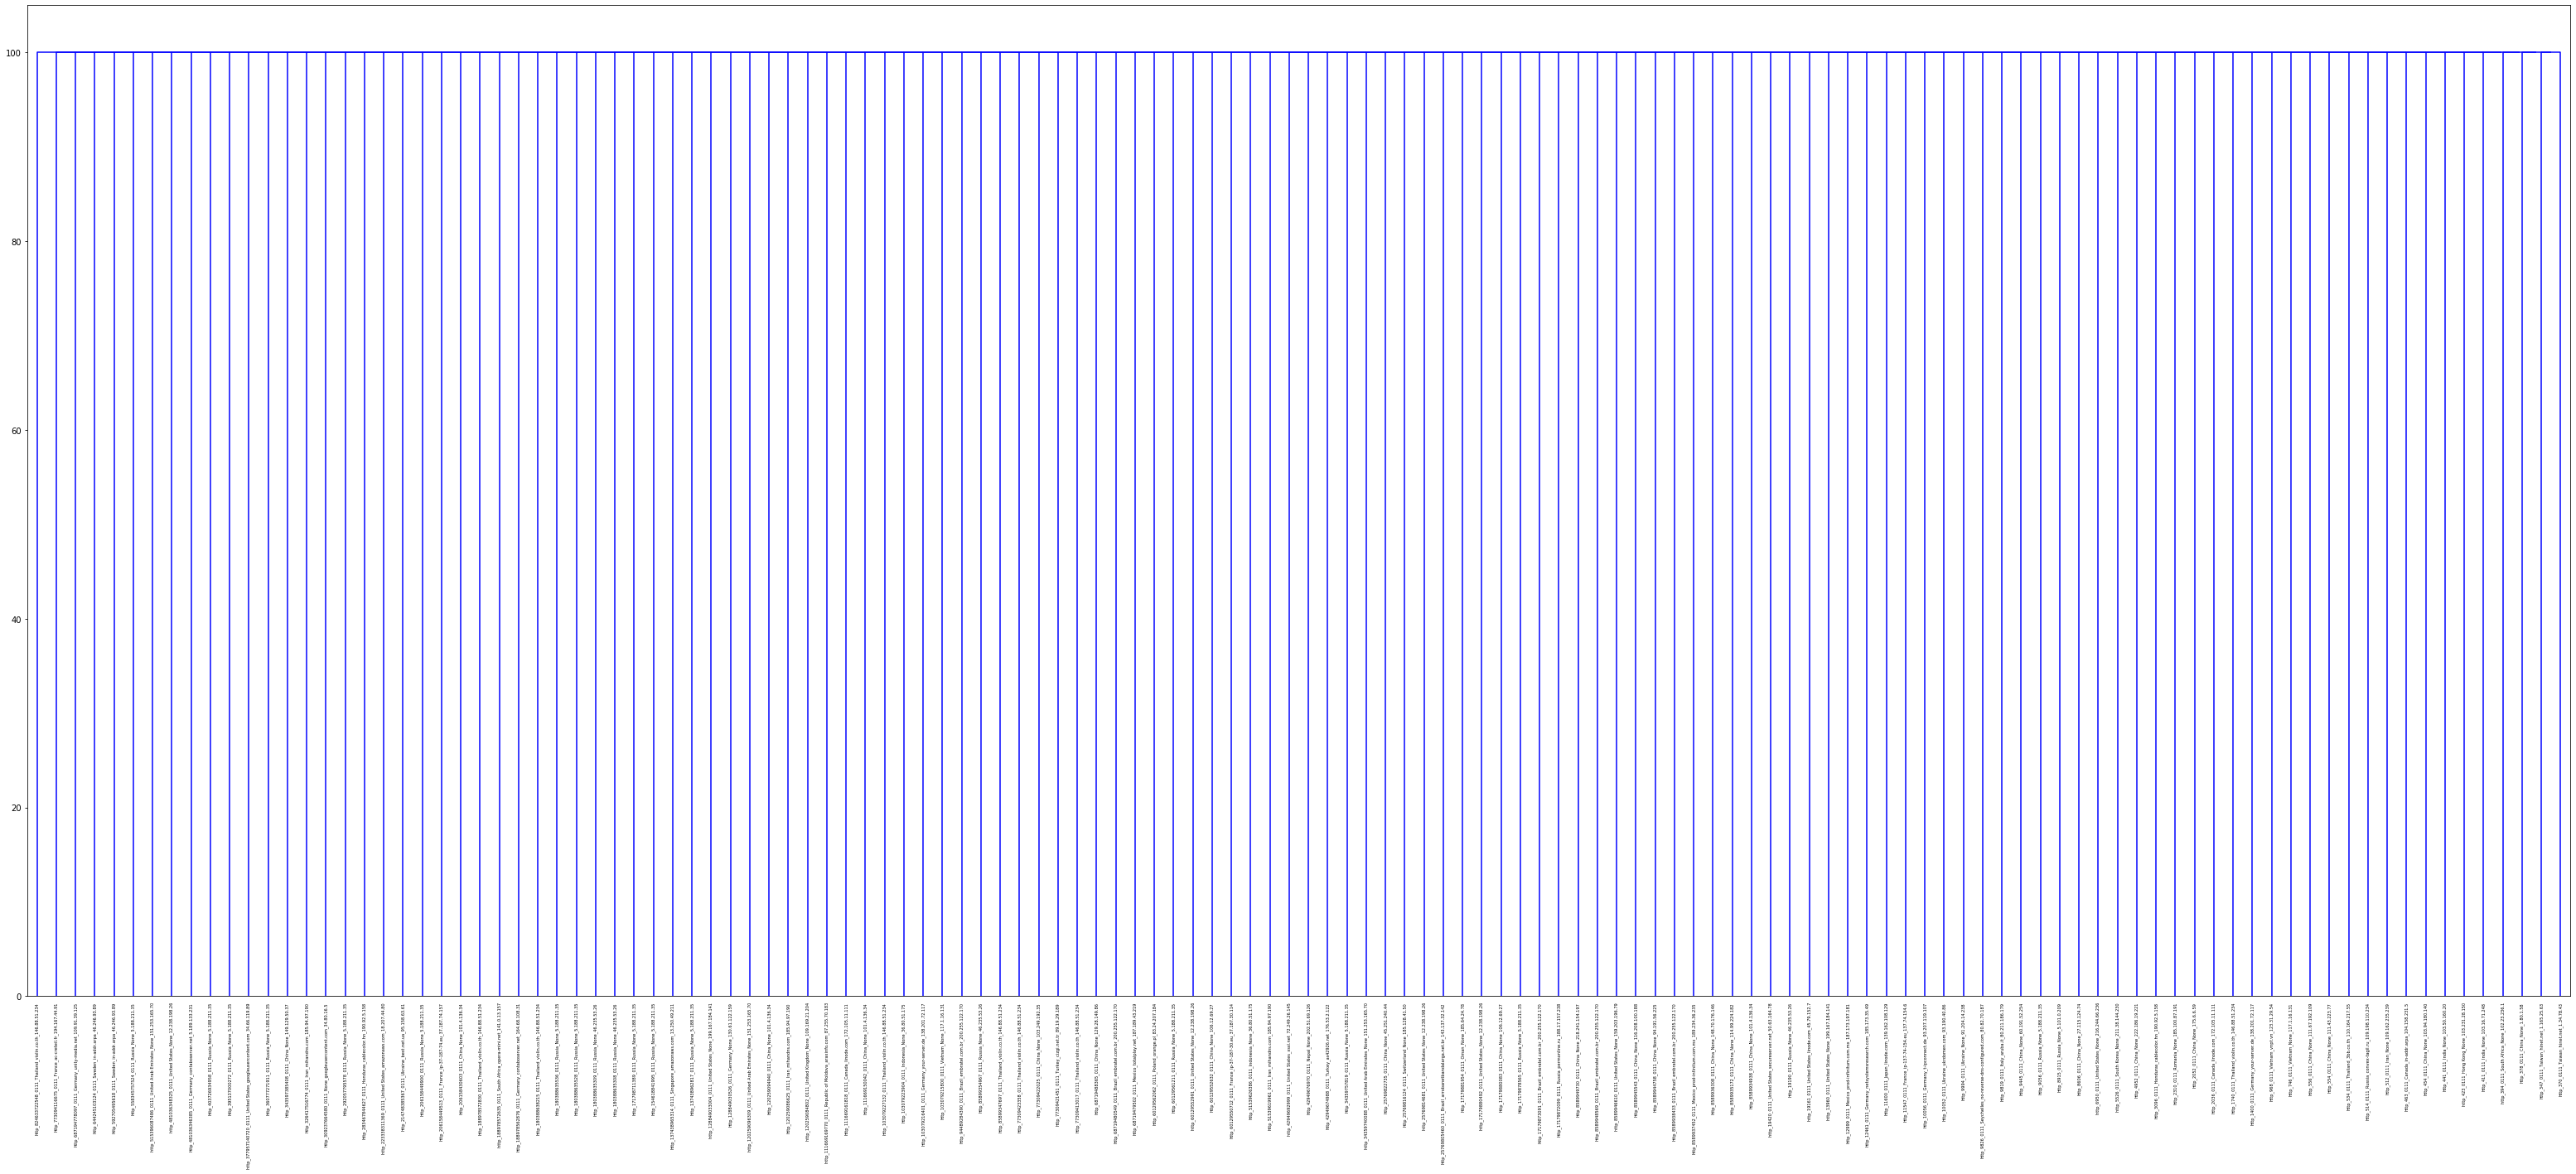

In [20]:
http_upgma_dict = cluster_rep_hash(http_big_dict,http_df_payload,http_df,date='0111',protocol='http')
pickle.dump(obj=http_upgma_dict,file=open(pickle_dir+'http_upgma_dict_0111.pkl','wb'))
http_upgma_df = pair_wise_score(http_upgma_dict)
draw_upgma(http_upgma_df,name='0111_upgma')

In [28]:
path = pickle_dir+'0110_http_loner_df.pkl'
path = path.replace('_11','_10')
http_loner_df = pickle.load(open(path,'rb'))
http_loner_df

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,isp,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
3366603,1.578642e+09,"[1578641803.689616, 1578641803.689806, 1578641...",5.519835,822,483,339,1621558,26422.0,1595136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1577128.0,328.0,1576800.0,0.679089,4651.327434,203.150.154.191,210.242.149.157,46444.0,80.0,NaN,NaN,Thailand,Chiang Mai,Chiang Mai,inet.co.th,Internet Thailand Company Limited,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines,[[24:Da7MgD3Wlt8FYp4o032B9ih032B9iU6ZYle:Da7nW...,[[96:bqb46gCp4QuQxr9hEjqozJnsnSnrnb0MyAPJVHbOL...
6832388,1.578617e+09,"[1578617320.535536, 1578617320.53576, 15786173...",6.380678,11,6,5,1161,821.0,340.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.0,441.0,2.0,73.500000,0.400000,149.129.50.37,210.242.149.53,45532.0,8080.0,NaN,NaN,China,None,None,None,Alibaba,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data,[[24:3/6tMAaw9cOTH3cx9cOFUvcHTbzJJ0Zs2CsLN/65I...,"[[3:Sn:Sn, 1578617326.863735000, 2]]"
7984647,1.578596e+09,"[1578596040.180659, 1578596040.181096, 1578596...",31.179855,832,459,373,1123967,33613.0,1090354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1066779.0,1051.0,1065728.0,2.289760,2857.179625,5.188.211.35,210.242.148.151,56653.0,80.0,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form,eth:ethertype:ip:tcp:http:data-text-lines,[[96:RCx1uw1Cf9fzyY1kOQQ4gUOW1c5eu5zWZ:RCEf9fz...,[[96:1b4l1Cp4QuQxr9pHjqozJnsnSnrnb0Kdr/D18:pi8...
10873635,1.578628e+09,"[1578627974.136787, 1578627974.137149, 1578627...",40.537868,70,45,25,105835,16843.0,88992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101833.0,14233.0,87600.0,316.288889,3504.000000,172.80.253.50,210.242.148.179,36006.0,80.0,NaN,NaN,Iran,None,None,None,Mobile Communication Company of Iran PLC,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form,eth:ethertype:ip:tcp:http:data-text-lines,[[96:R/i1uw1CFBY1kXtJs3m5znXFm50m5/P6QVnXN69f6...,[[96:bjb4ZCp4QuQxr9LjqozJnsnSnrnb0sHtUd+xRE3c:...
11519214,1.578598e+09,"[1578597921.149954, 1578597921.150251, 1578597...",21.646746,780,425,355,1095338,30788.0,1064550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1042162.0,1050.0,1041112.0,2.470588,2932.709859,5.188.211.35,210.242.145.157,46391.0,80.0,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form,eth:ethertype:ip:tcp:http:data-text-lines,[[96:RNx1uw1CWCzY1kxIICmEFh95xelchRIE9:RNEWCjx...,[[96:qyb44Cp4QuQxr9ejqozJnsnSnrnb0xAsiSQo8ko:q...
18250590,1.578628e+09,"[1578628372.93373, 1578628372.933942, 15786283...",31.924667,32,16,16,52151,15351.0,36800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50351.0,14471.0,35880.0,904.437500,2242.500000,200.255.122.170,210.242.145.150,4965.0,80.0,NaN,NaN,Brazil,Rio de Janeiro,Rio de Janeiro,embratel.com.br,Claro S.A.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data,eth:ethertype:ip:tcp:http:data-text-lines,[[48:R1Aa4tP/nY18n/0Oy218hw18JPrBXxc29nXflrBXx...,[[96:b9b4+2Cp4QuQxr9NjqozJnsnSnrnb0QYGyftbRK:b...
20099388,1.

In [45]:
http_loner_df[http_loner_df.index==18250590].ip_src.values[0]

'200.255.122.170'

In [34]:
http_loner_df_payload = prepare_df(http_loner_df,loner=True)
http_loner_df_payload

/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

,idx,size,hash
0,3366603,24,24:Da7MgD3Wlt8FYp4o032B9ih032B9iU6ZYle:Da7nWlt...
1,6832388,24,24:3/6tMAaw9cOTH3cx9cOFUvcHTbzJJ0Zs2CsLN/65I2e...
2,7984647,96,96:RCx1uw1Cf9fzyY1kOQQ4gUOW1c5eu5zWZ:RCEf9fz89...
3,10873635,48,48:0X6nXf9FXC2+CF032nXf9LLf+CMPgIYnXflmmIK+odI...
4,10873635,96,96:iJU7PinXNri3qnXF/q3A4nXFA5A23e8TnXFe8se8V3I...
5,10873635,96,96:iUqV3+MnXF+t+GPrvNnXNrcHreI3x0T7tnXFx0m7vx0...
6,10873635,96,96:R/i1uw1CFBY1kXtJs3m5znXFm50m5/P6QVnXN69f6nQ...
7,11519214,96,96:RNx1uw1CWCzY1kxIICmEFh95xelchRIE9:RNEWCjxIf...
8,18250590,96,96:CTPU8nXNUhUs3U/nXFU4UNPTLZenXNTSZYTV0Z33U3c...
9,18250590,96,96:WPcsTnXNcsCcsp3EznXFVBZO3iUtZpnXFiUYZLiUsZc...


In [48]:
http_df[http_df.ip_src == '200.255.122.170'].index

Int64Index([  8589938433,   8589948569,  17179873091,  25769817699,
             68719480549,  77309415090,  77309415091,  77309425448,
             85899359999,  94489284390,  94489284391,  94489284392,
            103079219040, 120259088143, 137438967760, 146028902264,
            163208761065, 231928248183, 231928248184, 240518172364,
            309237659506, 335007463163, 343597387607, 352187322197,
            395136995048, 395137005148, 429496733421, 446676602692,
            515396079333, 523986023844, 532575959031, 549755817764,
            558345752247, 558345752248, 566935686841, 566935697140,
            575525621406, 592705500835, 609885359934, 627065229061,
            627065238948, 652835042972, 678604836663, 678604846920,
            687194771285, 712964574972, 730144454291, 738734378751,
            755914248090, 798863931022, 798863931023, 850403528408],
           dtype='int64')

In [49]:
http_loner_df_payload.idx

0      3366603
1      6832388
2      7984647
3     10873635
4     10873635
5     10873635
6     10873635
7     11519214
8     18250590
9     18250590
10    18250590
11    18250590
12    18250590
13    18250590
14    18250590
15    20099388
16    20692536
17    26324141
18    31541764
19    31541764
20    31541764
21    31541764
22    31541764
23    31541764
24    31957360
25    33727731
26    34447107
27    37120540
28    37120540
29    37120540
30    37120540
31    37120540
32    37120540
33    37120540
34    37120540
35    37594846
36    38885463
37    38885463
38    38885463
39    38885463
40    38885463
41    38885463
42    38885463
43    38885463
44    45949301
45    45949301
46    45949301
47    45949301
48    48610537
Name: idx, dtype: int64

In [56]:
http_big_dict_loner,http_loners_loner,http_score_loner,http_cluster_score_dict_loner = similarity_compare(http_loner_df,http_loner_df_payload,http_df,http_df_payload,loner=True)

  0%|          | 0/18 [00:00<?, ?it/s]/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [60]:
http_df.loc[[395136995048, 712964574972]]

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,isp,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
395136995048,1.578686e+09,"[1578685856.534379, 1578685856.53455, 15786858...",1.881225,30,13,17,68724,15328,53396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67058,14618,52440,1124.461538,3084.705882,200.255.122.170,210.242.149.134,22272,80,NaN,NaN,Brazil,Rio de Janeiro,Rio de Janeiro,embratel.com.br,Claro S.A.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data,eth:ethertype:ip:tcp:http:data-text-lines,[[48:R1Aa4tBnY18nOtTGZg18hw18JTPmrFZrsnXflmrTE...,[[96:b7b4lCp4QuQxr9LjqozJnsnSnrnb0yQ2BA01k:bfJ...
712964574972,1.578693e+09,"[1578693475.380074, 1578693475.380275, 1578693...",1.946603,34,16,18,71776,15560,56216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69888,14688,55200,918.000000,3066.666667,200.255.122.170,210.242.145.150,62174,80,NaN,NaN,Brazil,Rio de Janeiro,Rio de Janeiro,embratel.com.br,Claro S.A.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data,eth:ethertype:ip:tcp:http:data-text-lines,[[48:R1Aa4tP/nY18nYbGKQM218hw1879x23ERBwbVnXf9...,[[96:beb4wCp4QuQxr9njqozJnsnSnrnb0cRnTm3x3yCdm...


In [61]:
http_df[(http_df.ip_dst == '210.242.145.150')&(http_df.ip_src=='200.255.122.170')]

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,isp,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
712964574972,1.578693e+09,"[1578693475.380074, 1578693475.380275, 1578693...",1.946603,34,16,18,71776,15560,56216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69888,14688,55200,918.0,3066.666667,200.255.122.170,210.242.145.150,62174,80,NaN,NaN,Brazil,Rio de Janeiro,Rio de Janeiro,embratel.com.br,Claro S.A.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:data,eth:ethertype:ip:tcp:http:data-text-lines,[[48:R1Aa4tP/nY18nYbGKQM218hw1879x23ERBwbVnXf9...,[[96:beb4wCp4QuQxr9njqozJnsnSnrnb0cRnTm3x3yCdm...


In [70]:
clustered_session = []
for v in http_big_dict_loner.values():
    clustered_session.extend(v)
clustered_session = list(set(clustered_session))
loner_srcip_li = http_loner_df.ip_src.unique().tolist()
loner_dstip_li = http_loner_df.ip_dst.unique().tolist()

In [71]:
suspicious = http_df[~http_df.index.isin(clustered_session)]
suspicious = suspicious[suspicious.ip_src.isin(loner_srcip_li)]
suspicious = suspicious[suspicious.ip_dst.isin(loner_dstip_li)]
suspicious

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,isp,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
9065,1.578714e+09,"[1578713504.302222, 1578713504.302599, 1578713...",25.184105,790,436,354,1095327,30835,1064492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1041335,223,1041112,0.511468,2940.994350,5.188.211.35,210.242.145.173,35419,80,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines,[[12:tA26LJTsU5SHXqLHCYTI75cuXNFdVj5NkH18YH14N...,[[96:oBb4FCp4QuQxr9UjqozJnsnSnrnb0cnI7YWA5vZqo...
9066,1.578747e+09,"[1578747236.547948, 1578747236.548244, 1578747...",35.652386,762,415,347,970621,29679,940942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,918265,233,918032,0.561446,2645.625360,5.188.211.35,210.242.145.173,49988,80,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines,[[12:7Klhkgh21PmHXqLHCYTI75cuXNFdVj5NkH18YH14N...,[[96:9b4GrCp4QuQxr9NtjqozJnsnSnrnb0sYmA+5K4tCz...
9075,1.578711e+09,"[1578711496.886595, 1578711496.886809, 1578711...",17.317600,849,463,386,1111584,33404,1078180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1053402,706,1052696,1.524838,2727.191710,5.188.211.35,210.242.148.137,38766,80,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form,eth:ethertype:ip:tcp:http:data-text-lines,[[48:Ro2AaButFI18hw18dpHod1Y18nMjItrwlDDe8E/:R...,[[96:ab41Cp4QuQxr9PjqozJnsnSnrnb0QuAiY:Azp5uwr...
19374,1.578709e+09,"[1578709198.480236, 1578709198.480449, 1578709...",36.340473,125,67,58,172389,4917,167472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163839,215,163624,3.208955,2821.103448,5.188.211.35,210.242.148.149,44362,80,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines,[[12:7vYHXqLHCYTI75cuXNFdVj5NkH18YH14NIL18YH1I...,[[96:qb4LCp4QuQxr9njqozJnsnSnrnb0IkAsgt:wnp5uw...
19380,1.578711e+09,"[1578711201.752999, 1578711201.753289, 1578711...",25.143415,57,32,25,73511,2349,71162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69733,229,69504,7.156250,2780.160000,5.188.211.35,210.242.148.183,36908,80,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines,[[12:tAexmHXqLHCYTI75cuXNFdVj5NkH18YH14NIL18YH...,[[96:Rb4gCp4QuQxr9njqozJnsnSnrnb0C41icRXR4RtCq...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841813609751,1.578734e+09,"[1578734461.237297, 1578734461.23787, 15787344...",42.749321,46,18,28,39602,1506,38096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36426,226,36200,12.555556,1292.857143,5.188.211.35,210.242.148.183,43776,80,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data,[[12:tA954GmHXqLHCYTI75cuXNFdVj5NkH18YH14NIL18...,[[96:jb47Cp4QuQxr9Ij

In [72]:
http_loner_df[http_loner_df.ip_src == '5.188.211.35']

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,isp,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
7984647,1.578596e+09,"[1578596040.180659, 1578596040.181096, 1578596...",31.179855,832,459,373,1123967,33613.0,1090354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1066779.0,1051.0,1065728.0,2.289760,2857.179625,5.188.211.35,210.242.148.151,56653.0,80.0,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form,eth:ethertype:ip:tcp:http:data-text-lines,[[96:RCx1uw1Cf9fzyY1kOQQ4gUOW1c5eu5zWZ:RCEf9fz...,[[96:1b4l1Cp4QuQxr9pHjqozJnsnSnrnb0Kdr/D18:pi8...
11519214,1.578598e+09,"[1578597921.149954, 1578597921.150251, 1578597...",21.646746,780,425,355,1095338,30788.0,1064550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1042162.0,1050.0,1041112.0,2.470588,2932.709859,5.188.211.35,210.242.145.157,46391.0,80.0,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form,eth:ethertype:ip:tcp:http:data-text-lines,[[96:RNx1uw1CWCzY1kxIICmEFh95xelchRIE9:RNEWCjx...,[[96:qyb44Cp4QuQxr9ejqozJnsnSnrnb0xAsiSQo8ko:q...
20099388,1.578655e+09,"[1578655437.829349, 1578655437.829666, 1578655...",13.581244,679,350,329,1154348,24906.0,1129442.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1108918.0,1198.0,1107720.0,3.422857,3366.930091,5.188.211.35,210.242.148.190,41921.0,80.0,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form,eth:ethertype:ip:tcp:http:data-text-lines,[[96:R3x1uw1CYgkSY1k1EUSoAAJEXU8WQbc0vo8QSN8pP...,[[96:bib4ECp4QuQxr90jqozJnsnSnrnb0E1fmjEiRZyZe...
31957360,1.578650e+09,"[1578649501.906186, 1578649501.906381, 1578649...",13.427934,450,243,207,595083,18141.0,576942.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,564451.0,1179.0,563272.0,4.851852,2721.120773,5.188.211.35,210.242.145.173,52525.0,80.0,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form,eth:ethertype:ip:tcp:http:data-text-lines,[[96:8ox1uw1CIkY1kDrzpD/iuN3deqVmeXRbWfdjb:8oE...,[[96:bEb4lhCp4QuQxr9zjqozJnsnSnrnb0Ssxub0EYWqX...
48610537,1.578656e+09,"[1578655982.240809, 1578655982.241024, 1578655...",3.383199,72,41,31,80469,4567.0,75902.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75533.0,1685.0,73848.0,41.097561,2382.193548,5.188.211.35,210.242.149.167,38743.0,80.0,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http:urlencoded-form,eth:ethertype:ip:tcp:http:data-text-lines,[[96:RAdx1uw1CjtAya6ZY1kNiWC9ZbR0WaB8W2SfAVLf7...,[[96:bmb4tRCp4QuQxr9ezjqozJnsnSnrnb081JQKREgy6...


原本總共sessions#: 18
共有#sessions可分群: 398 共有#lonerSessions: -380
可分為#群: 11
前三大的cluster key與對應之群集大小
 20099388    101
11519214     83
31957360     72
7984647      59
48610537     55
Name: 0, dtype: int64
                0
count   11.000000
mean    36.181818
std     38.170193
min      2.000000
25%      3.000000
50%     10.000000
75%     65.500000
max    101.000000


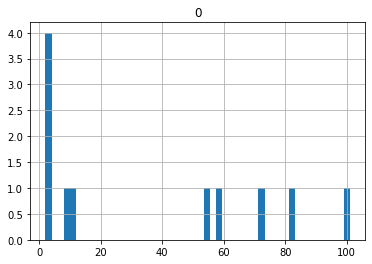

In [54]:
cluster_stat(http_big_dict_loner,http_loner_df,drawlog=False)

In [73]:
http_loner_df.ip_src.unique()

array(['203.150.154.191', '149.129.50.37', '5.188.211.35',
       '172.80.253.50', '200.255.122.170', '106.12.69.27',
       '195.154.200.161', '109.169.21.204', '5.188.210.65',
       '213.87.148.112', '94.23.20.187', '146.88.51.234'], dtype=object)

In [99]:
# 不同天、同srcip、同protocol、同dstip、不同payload content=>APT
c_ip = '5.188.211.35'
d_ips = http_loner_df[http_loner_df.ip_src == c_ip].ip_dst.tolist()
print(len(d_ips))
suspicious[(suspicious.ip_src == c_ip)&(suspicious.ip_dst.isin(d_ips))]

5


,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,isp,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
9065,1.578714e+09,"[1578713504.302222, 1578713504.302599, 1578713...",25.184105,790,436,354,1095327,30835,1064492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1041335,223,1041112,0.511468,2940.994350,5.188.211.35,210.242.145.173,35419,80,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines,[[12:tA26LJTsU5SHXqLHCYTI75cuXNFdVj5NkH18YH14N...,[[96:oBb4FCp4QuQxr9UjqozJnsnSnrnb0cnI7YWA5vZqo...
9066,1.578747e+09,"[1578747236.547948, 1578747236.548244, 1578747...",35.652386,762,415,347,970621,29679,940942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,918265,233,918032,0.561446,2645.625360,5.188.211.35,210.242.145.173,49988,80,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines,[[12:7Klhkgh21PmHXqLHCYTI75cuXNFdVj5NkH18YH14N...,[[96:9b4GrCp4QuQxr9NtjqozJnsnSnrnb0sYmA+5K4tCz...
8589953876,1.578673e+09,"[1578672698.365285, 1578672698.365674, 1578672...",30.728468,871,485,386,1122775,34459,1088316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1063053,221,1062832,0.455670,2753.450777,5.188.211.35,210.242.145.173,47359,80,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines,[[12:tA9tzHXqLHCYTI75cuXNFdVj5NkH18YH14NIL18YH...,[[96:b1b47Cp4QuQxr9VjqozJnsnSnrnb0pEJFkZlp9:bp...
25769812829,1.578691e+09,"[1578690726.833976, 1578690726.834191, 1578690...",27.246490,810,448,362,1119343,31163,1088180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1064511,231,1064280,0.515625,2940.000000,5.188.211.35,210.242.145.157,58081,80,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines,[[12:tA9wlyPmHXqLHCYTI75cuXNFdVj5NkH18YH14NIL1...,[[96:bzb4rCp4QuQxr99jqozJnsnSnrnb0EB5v9+BVZ/:b...
34359757805,1.578747e+09,"[1578746803.687782, 1578746803.688151, 1578746...",16.500181,622,342,280,865044,24092,840952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,822708,244,822464,0.713450,2937.371429,5.188.211.35,210.242.148.151,44065,80,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines,[[12:tAFDrDXu0s61dHXqLHCYTI75cuXNFdVj5NkH18YH1...,[[96:2b4xCp4QuQxr95jqozJnsnSnrnb0IyWn0LgsiHlZO...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824633740177,1.578704e+09,"[1578704271.959806, 1578704271.960068, 1578704...",35.636909,176,100,76,239628,7268,232360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227624,288,227336,2.880000,2991.263158,5.188.211.35,210.242.148.151,40793,80,NaN,NaN,Russia,None,None,None,Petersburg Internet Network ltd.,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:http,eth:ethertype:ip:tcp:http:data-text-lines,[[24:tAeuE65rFCfDXmajCYE9cOFtS18YH+w1

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,isp,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list


In [277]:
# 合併三個dict用update來合併以後再通過後面的df function畫圖。大家的pickle_dir都不同0109 0110 0111
three_dict = {}
path = pickle_dir+'http_upgma_dict_0110.pkl'
temp = pickle.load(open(path,'rb'))
three_dict.update(temp)
path = path.replace('10','09')
temp = pickle.load(open(path,'rb'))
three_dict.update(temp)
path = path.replace('09','11')
temp = pickle.load(open(path,'rb'))
three_dict.update(temp)
three_dict

{'0110_http_124_India_1.186.242.12': '96:FZpnXFLZLhZc34kYOFnXF4kYO+4kYOh3UOQnXFUOxUOI3onXFhAV:FTnVLhhu34kYMnV4kYF4kYG3UBnVUyUv',
 '0110_http_1828_Thailand_101.109.250.86': '12:E8S8EmHXq/Ish+j51h6Y1awh5UP+/4D7eh2xmMReUuC9LH46ZY1Zu8m:2zAawQQ5HltuMM7n9j46ZY1Zuv',
 '0110_http_92_Taiwan_1.169.112.69': '6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHXq6xmMRe9SNYV3NkZr8m',
 '0110_http_3228_India_103.50.160.20': '96:isgnGt0b6R/4OVIPiZcD9WkLqBQX2dw3pyTslefYTsypsTelYxv:fgnGt0b6R/4OVIPiZcD9WkLqBQX2dw3A',
 '0110_http_3665_United States_104.236.37.149': '24:tAoH5BBBBBBBBBBB1owbAs+rX+rQ+rd+r2+rL+rXD8oa7MyIv:+oHH1FVgnGt0g8oa7M',
 '0110_http_185275_Seychelles_80.82.70.187': '12:Bp0LTEKXfAPHXq6xs0LTPI+icmbYExUp9+m:30nEKXoPaH0ngRxzxUd',
 '0110_http_5764_China_111.21.193.20': '3:cRm5tD+U/Y7Ejfun:rHKAqEjmn',
 '0110_http_10090_Vietnam_117.1.16.131': '24:7jVUy6zWB+ca7MzWRy9IDafC686ZY1ZudCY8+M8f:7L6z8a7Ly26hSk3HJf',
 '0110_http_2394_India_103.16.71.248': '48:+5V6G6Q6P56AA6D6Q6d6iN3Y6So6Sz6G6KQaDw/+6kyXPSkLPz:+

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [55.0, 55.0, 65.0, 65.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [60.0, 60.0, 82.5, 82.5],
  [125.0, 125.0, 135.0, 135.0],
  [115.0, 115.0, 130.0, 130.0],
  [105.0, 105.0, 122.5, 122.5],
  [155.0, 155.0, 165.0, 165.0],
  [145.0, 145.0, 160.0, 160.0],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [185.0, 185.0, 202.5, 202.5],
  [175.0, 175.0, 193.75, 193.75],
  [152.5, 152.5, 184.375, 184.375],
  [113.75, 113.75, 168.4375, 168.4375],
  [71.25, 71.25, 141.09375, 141.09375],
  [255.0, 255.0, 265.0, 265.0],
  [245.0, 245.0, 260.0, 260.0],
  [285.0, 285.0, 295.0, 295.0],
  [305.0, 305.0, 315.0, 315.0],
  [290.0, 290.0, 310.0, 310.0],
  [275.0, 275.0, 300.0, 300.0],
  [252.5, 252.5, 287.5, 287.5],
  [345.0, 345.0, 355.0, 355.0],
  [335.0, 335.0, 350.0, 350.0],
  [375.0, 375.0, 385.0, 385.0],
  [405.0, 405.0, 415.0, 415.0],
  [395.0, 395.0, 410.0, 410.0],
  [425.0, 425.0, 435.0, 435.0],


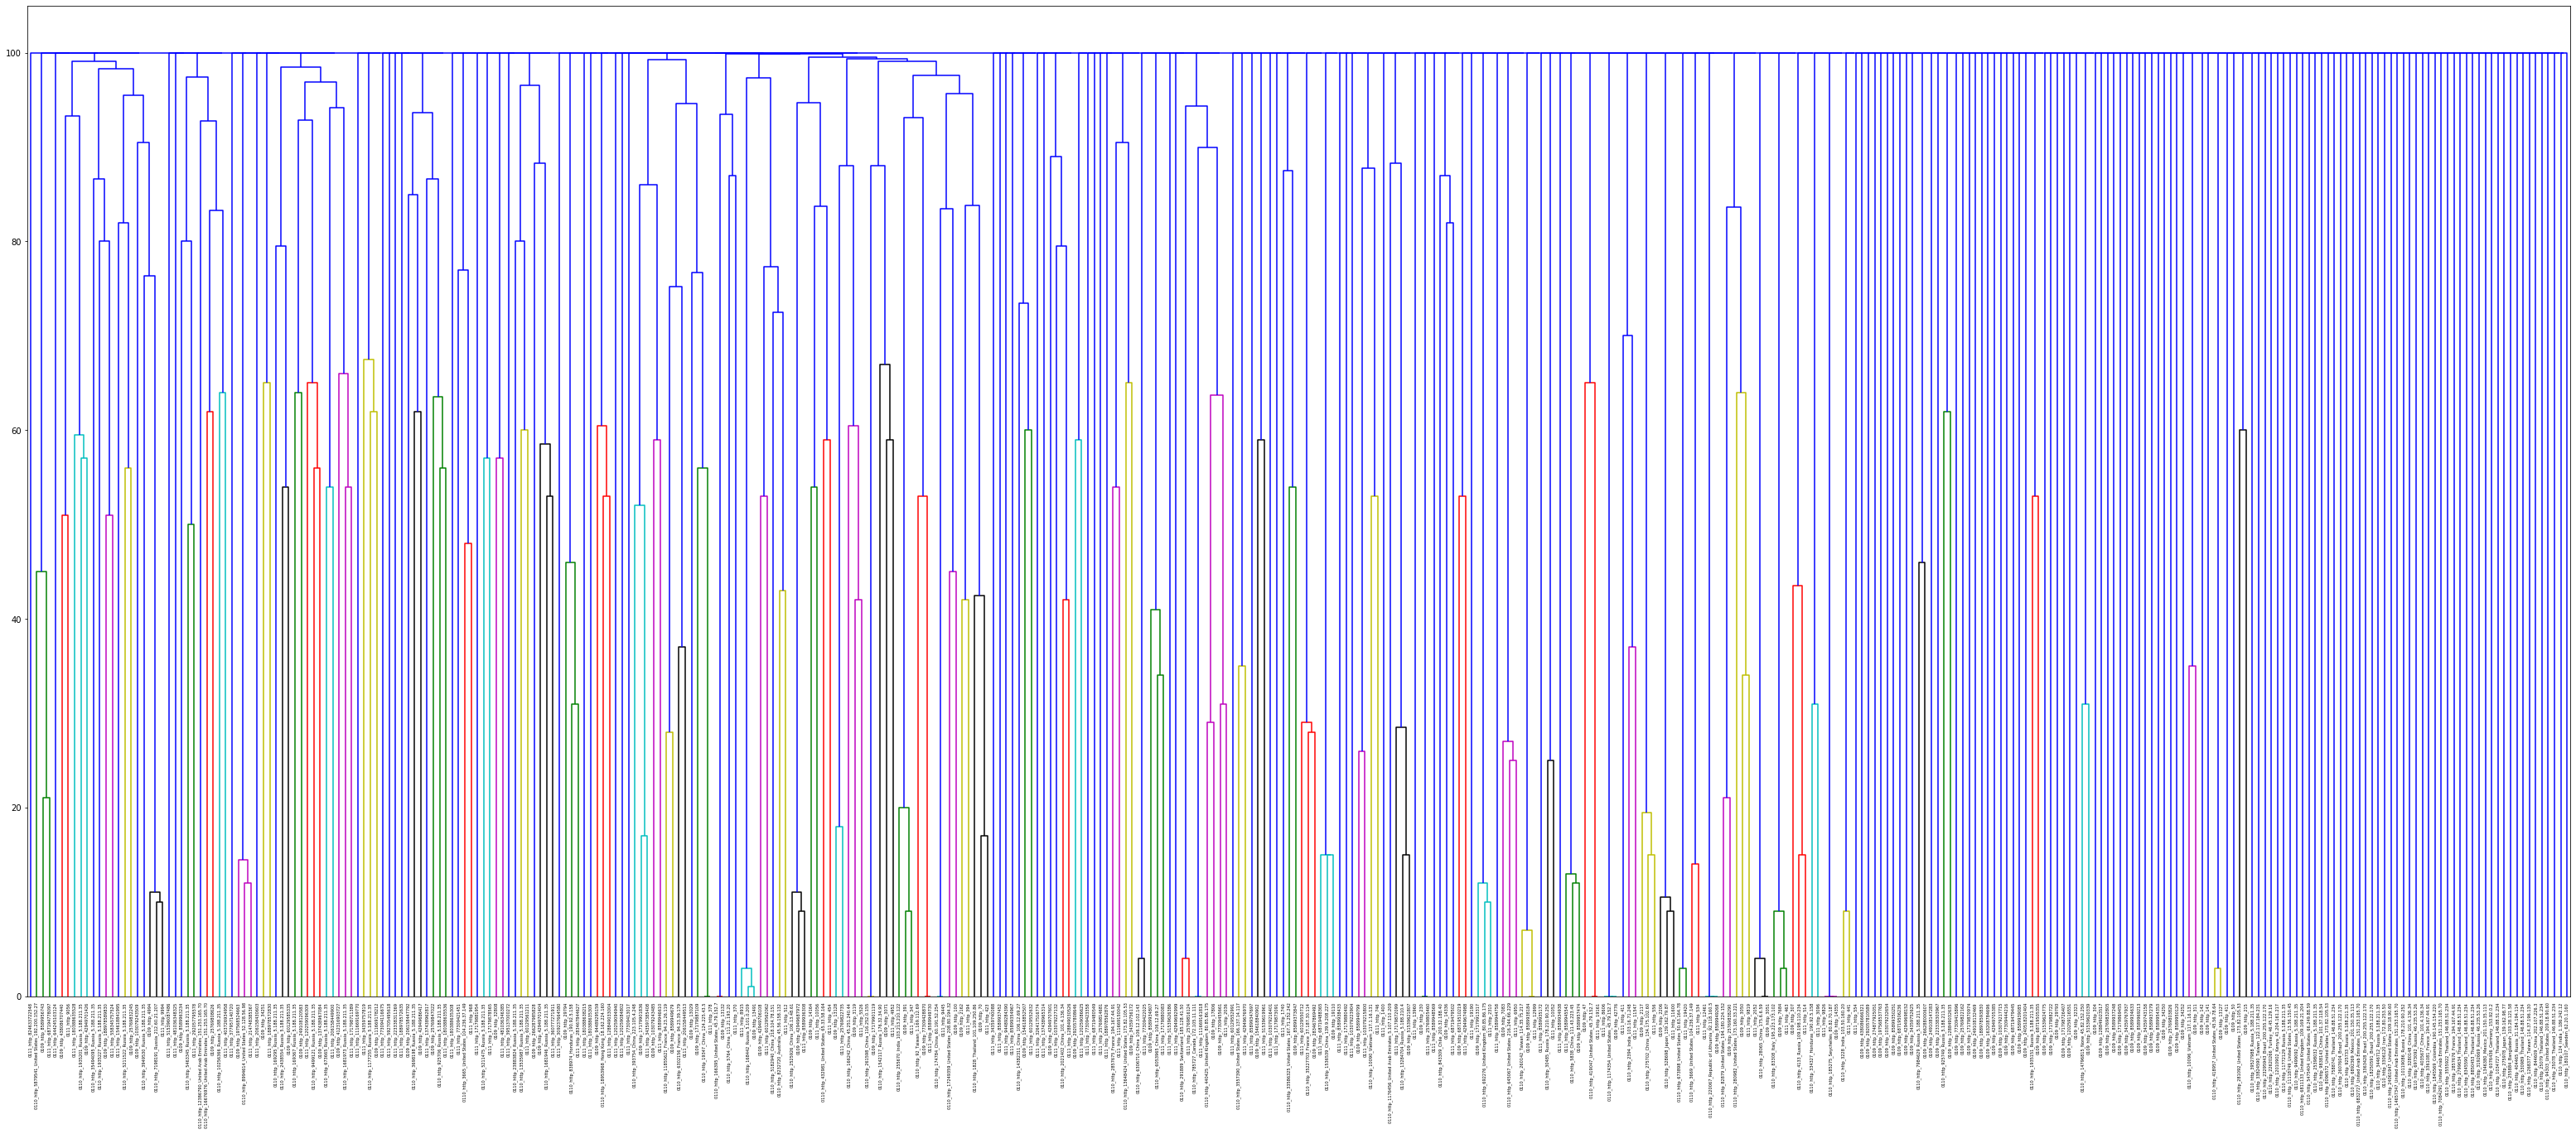

In [278]:
three_upgma_df = pair_wise_score(three_dict)
draw_upgma(three_upgma_df,name='0109-0110_upgma')

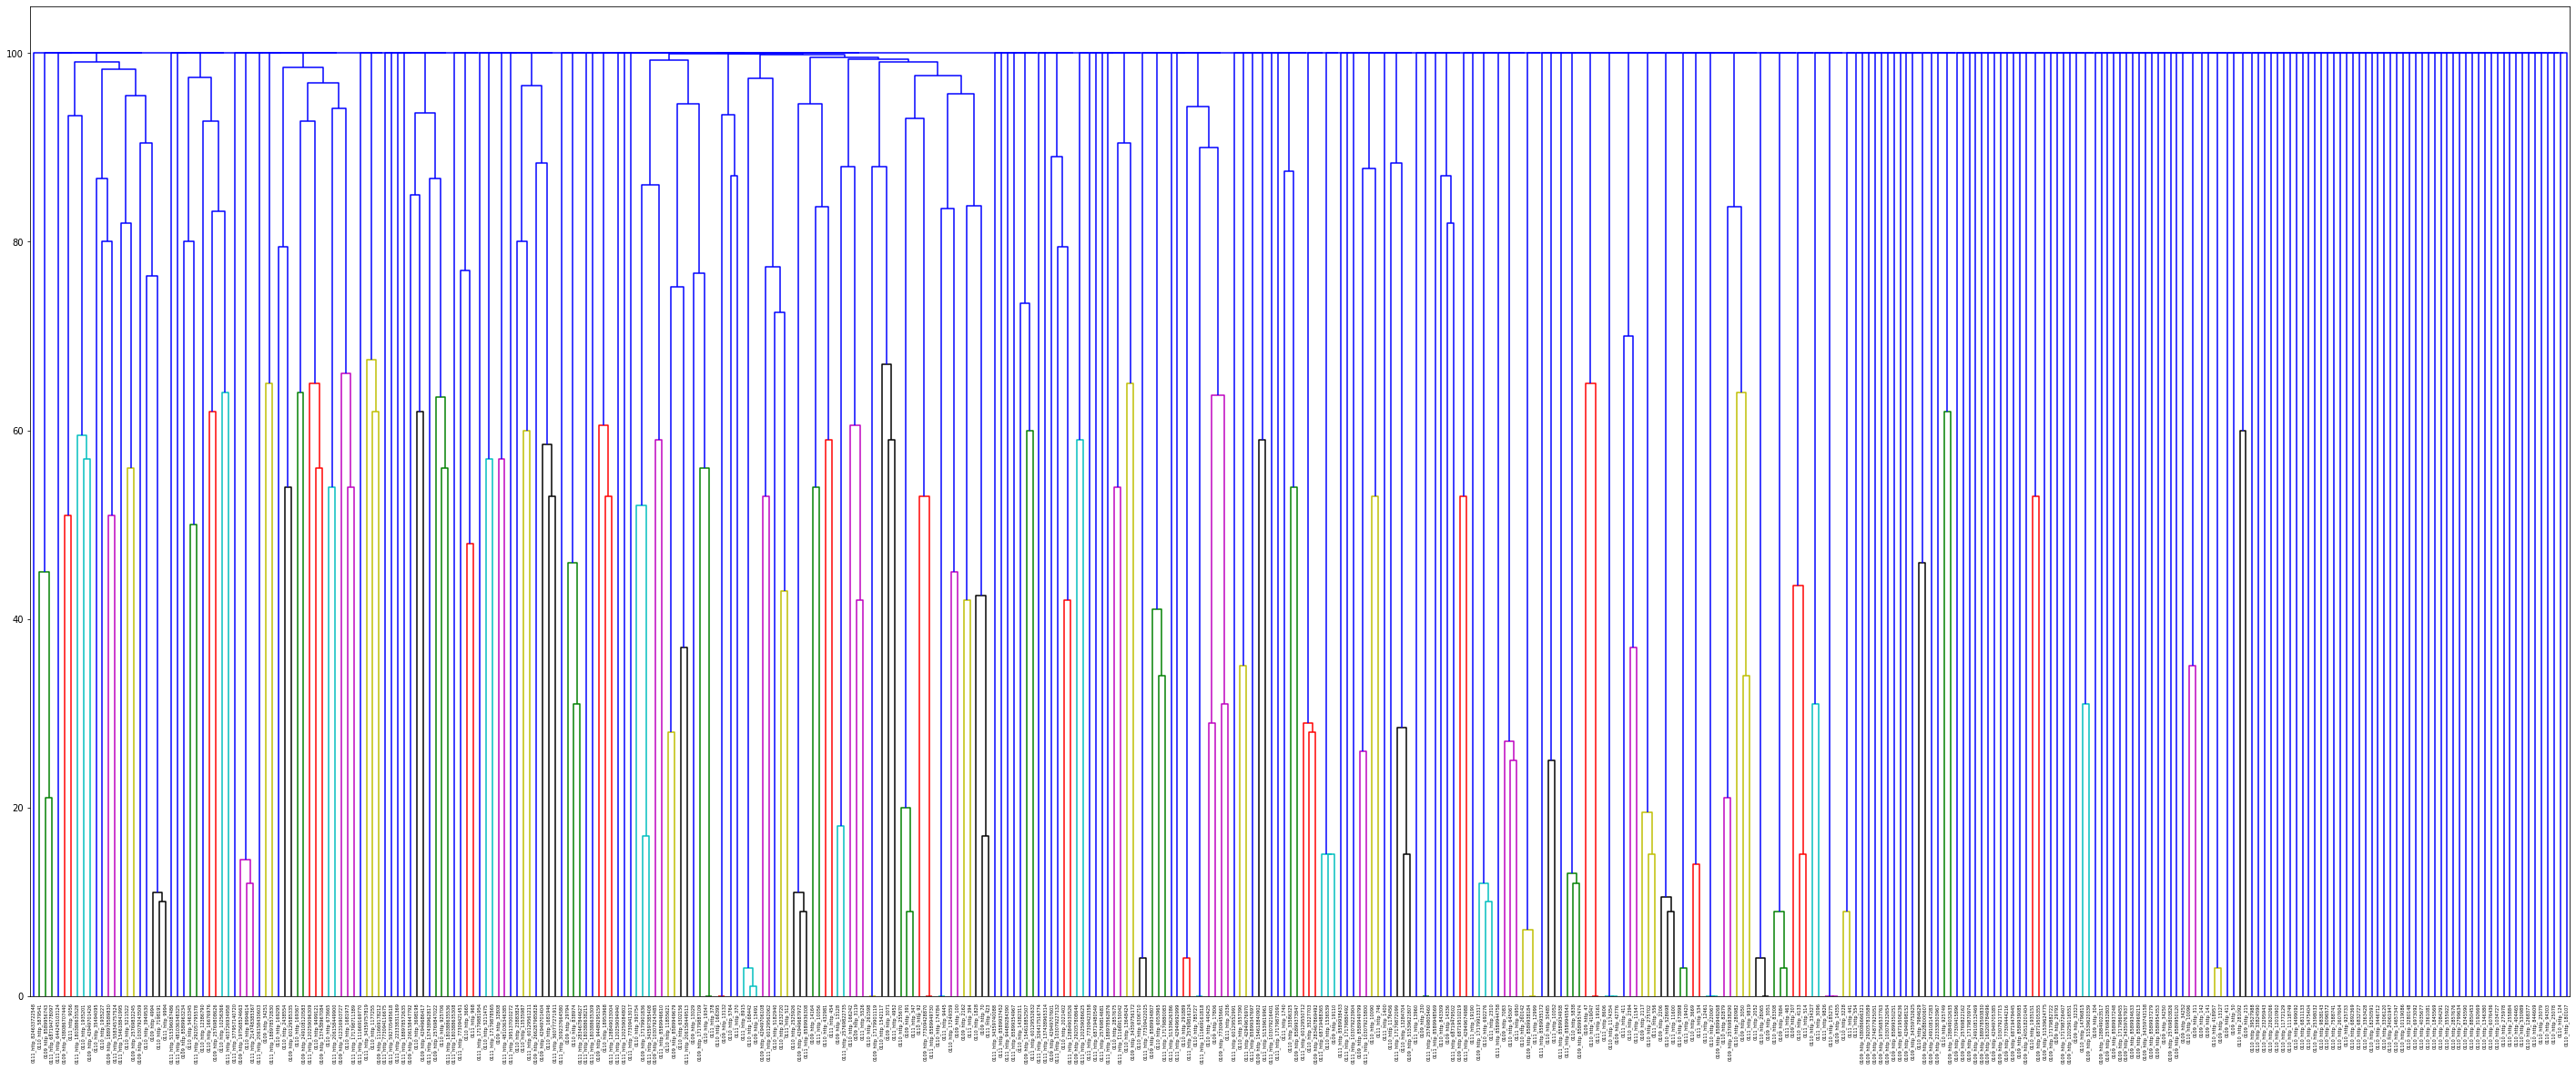

In [258]:
# upgma_dict = three_dict
# def compare(target_hash,candidate_hash_li):
#     score_li = []
#     for c_hash in candidate_hash_li:
#         score_li.append(100-ssdeep.compare(target_hash,c_hash)) #相似度滿分100，轉換成距離最近0
#     return score_li
# used_idx = []
# def create_hash_li(t_hash):
#     idx_set = set(upgma_df[upgma_df.ssdeep == t_hash].index)#[0]
#     same_hash_li = sorted(list(idx_set - set(used_idx)))
#     idx = same_hash_li[0]
#     used_idx.append(idx)
#     return upgma_df.loc[idx+1:]['ssdeep'].tolist()
# upgma_df = pd.DataFrame(upgma_dict.items(),columns=['cluster','ssdeep'])
# upgma_df['c_ssdeep_li'] = upgma_df.ssdeep.map(create_hash_li)
# upgma_df['score'] = upgma_df.apply(lambda x: compare(x.ssdeep, x.c_ssdeep_li), axis=1)
# # return upgma_df

# score_li = upgma_df['score'].tolist()
# score_li = list(filter(None, score_li))
# score_li = sum(score_li,[])
# Z = linkage(score_li, 'average')
# fig = plt.figure(figsize=(50, 20)) #(25,10)
# # plt.savefig(fig)
# dn = dendrogram(Z,labels=upgma_df.cluster.tolist())
# plt.savefig('plt3.png', dpi=600, format='png', bbox_inches='tight')

畫distribution
* 針對某單一case進行

In [12]:
def case_study(idx,payload_df):
    '''
    idx: which index is the dataframe's target?
    payload_df: protocol payload dataframe (packet-based)
    下面有一些參數可以改 (line19~23、27註解處)
    
    Return: Big dict
    '''
    big_dict = {}
    idx = int(idx)
    target = payload_df[payload_df.idx == idx]
    target = target.reset_index(drop=True)
    t_len = len(target)
    t_q1 = target.iloc[int(t_len*0.25),-1]
    t_q2 = target.iloc[int(t_len*0.5),-1]
    t_q3 = target.iloc[int(t_len*0.75),-1]
    candidate = payload_df[payload_df.idx != idx]
    candidate['idx'] = candidate.idx.astype(str)
    candidate_q1 = candidate[candidate['size']==target.iloc[int(t_len*0.25),-2]] #是否要match: match改成== 不match改成!=
    candidate['q1'] = ssdeep_compare(t_q1,candidate_q1)
    candidate_q2 = candidate[candidate['size']==target.iloc[int(t_len*0.5),-2]] # == or != (score=0)
    candidate['q2'] = ssdeep_compare(t_q2,candidate_q2)
    candidate_q3 = candidate[candidate['size']==target.iloc[int(t_len*0.75),-2]] #要找不像的時候要改成!=
    candidate['q3'] = ssdeep_compare(t_q3,candidate_q3)
    candidate = candidate.drop(['size','hash'],axis=1)
    candidate['score'] = candidate.max(axis=1)
    candidate = candidate[candidate.score>0] #相似度分數，數字越小速度愈快、數字越大越多群。要抓出幾分的人> == <
    candidate['idx'] = candidate.idx.astype(int)
    idx_li = candidate.idx.tolist()
    if len(idx_li)>0:
        big_dict[idx] = idx_li
    # len(big_dict.keys())
    print("所有該protocol與所給定之target的分數種類:",candidate.score.unique())
    print("總session數量:",len(big_dict[idx]))
    print("分數的分布:",candidate.score.value_counts().sort_index())
    print("分數的分布圖:",candidate.score.hist(bins=25))
    return big_dict, candidate

In [328]:
candidate.score.value_counts().sort_index()#.sum()

40.0     1
41.0     2
43.0    14
44.0    14
46.0     2
47.0    87
49.0    14
50.0    52
52.0     1
54.0    51
55.0     7
57.0    67
58.0    12
60.0    79
61.0    22
63.0    72
65.0    41
66.0    67
68.0    52
69.0    38
71.0    47
72.0    25
74.0    27
75.0    10
77.0    10
79.0     9
80.0    15
82.0     8
83.0    16
85.0     4
86.0    11
88.0     9
90.0     3
91.0     4
94.0     2
Name: score, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


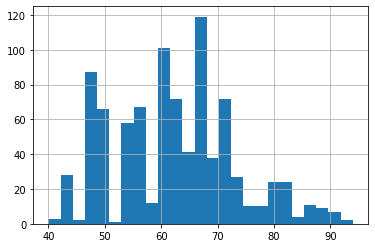

In [345]:
print(candidate.score.hist(bins=25))

In [315]:
candidate.score.describe()

count    895.000000
mean      62.375419
std       10.893108
min       40.000000
25%       54.000000
50%       63.000000
75%       69.000000
max       94.000000
Name: score, dtype: float64

In [13]:
def save_wireshark(df2_protocol,pkl_name,only_one=False):
    '''
    GOAL: save frame time list to pkl for Jerry to output wireshark pcap
    df2_protocol: protocol original dataframe (session-based)
    '''
    protocol_thr = df2_protocol.loc[big_dict_sqlmap[idx]]
    # protocol_thr = df2_protocol.loc[80891]  #也可只輸出一個特定sessiono的time frame list就好
    protocol_thr = protocol_thr.session_time_list.tolist()
    if not only_one:
        protocol_thr = [list(x) for x in protocol_thr]
    pickle.dump(obj=protocol_thr,file=open(pickle_dir+str(pkl_name)+'.pkl','wb'))
    print("總共具有的sessions數量:",len(protocol_thr))
# protocol_thr

sql map http

In [277]:
df2_http[df2_http.ip_src == '190.92.5.158'].index

Int64Index([   80890,    80891,    80892,   334327,   334328,   334329,
              334330,   334331,   334332,   334335,
            ...
            49785502, 50037370, 50037371, 50037372, 50290869, 50290870,
            50290871, 50290872, 50290873, 50290874],
           dtype='int64', length=819)

In [278]:
for k,v in big_dict_http.items():
    if 80891 in v:
        print(k)
        break

2394


In [279]:
case1_diagram = df2_http.loc[list(set(big_dict_http[2394]))]
time_lists = case1_diagram.session_time_list.tolist()
time_lists = [list(x) for x in time_lists]
ips = case1_diagram.ip_src.tolist()
countries = case1_diagram.country.tolist()
print(len(countries),len(ips))
# pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
pickle.dump(obj=(time_lists,ips,countries),file=open(pickle_dir+'case#1_threetuples.pkl','wb'))

905 905


In [280]:
case1_diagram.ip_src.unique()

array(['103.16.71.248', '117.1.16.131', '190.92.5.158', '109.198.110.234'],
      dtype=object)

#### SAMBA payload

In [53]:
smb_df, smb_df_payload = prepare_df(df2,'smb')
smb_big_dict = similarity_compare(smb_df,smb_df_payload)
gc.collect()

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

2

原本總共sessions#: 352131
共有#sessions可分群: 352131 共有#lonerSessions: 0
可分為#群: 2
前三大的cluster key與對應之群集大小
 10       351307
23848       824
Name: 0, dtype: int64
                   0
count       2.000000
mean   176065.500000
std    247828.905991
min       824.000000
25%     88444.750000
50%    176065.500000
75%    263686.250000
max    351307.000000


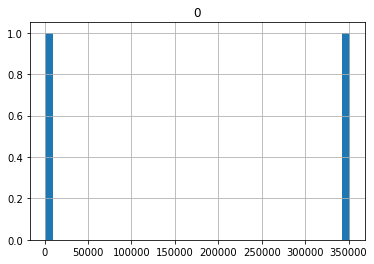

In [119]:
cluster_stat(smb_big_dict,smb_df)

In [122]:
write2pkl(smb_df,smb_big_dict,10,"smb_1")
write2pkl(smb_df,smb_big_dict,23848,"smb_2")
# write2pkl(smb_df,smb_big_dict,,"smb_3")


Unique Country#: 141 Unique IP#: 9056 Session#: 351307
Unique Country#: 31 Unique IP#: 133 Session#: 824


In [287]:
df2_smb[df2_smb.ip_src == '113.189.231.122']

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
512421,1.578621e+09,"[1578620529.412071, 1578620529.412273, 1578620...",120.234741,16,8,8,1508,808.0,700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596.0,364.0,232.0,45.500000,29.000000,113.189.231.122,210.242.148.79,63087.0,445.0,NaN,NaN,Vietnam,Bac Ninh,Tinh Bac Ninh,vnpt.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[3:11QRfDp03vV1V1Ud2FV1V1V1V1V1V1V1V1V1V1V1V1...,[[3:11QQoW503vV1V1cdcV1V1V1V1V1V1V1V1V1V133FfX...
3032491,1.578622e+09,"[1578621628.633667, 1578621628.633879, 1578621...",0.792706,19,8,11,1905,899.0,1006.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819.0,455.0,364.0,56.875000,33.090909,113.189.231.122,210.242.148.116,61267.0,445.0,NaN,NaN,Vietnam,Bac Ninh,Tinh Bac Ninh,vnpt.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcV...,[[6:iCV00dYMe9hNV9oEyoa0VfCy/a9evgfey9FV1RG/5r...
4040632,1.578621e+09,"[1578621227.633486, 1578621227.633716, 1578621...",0.497820,17,8,9,1785,899.0,886.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819.0,455.0,364.0,56.875000,40.444444,113.189.231.122,210.242.148.107,53067.0,445.0,NaN,NaN,Vietnam,Bac Ninh,Tinh Bac Ninh,vnpt.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcV...,[[6:iCV00dYMe9hNV9oEyoa0VfCy/a9evgfey9FV1RG/5r...
6309898,1.578622e+09,"[1578622269.756694, 1578622269.75692, 15786222...",120.353363,18,8,10,1628,808.0,820.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596.0,364.0,232.0,45.500000,23.200000,113.189.231.122,210.242.148.127,60517.0,445.0,NaN,NaN,Vietnam,Bac Ninh,Tinh Bac Ninh,vnpt.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[3:11QRfDp03vV1V1Ud2FV1V1V1V1V1V1V1V1V1V1V1V1...,[[3:11QQoW503vV1V1cdcV1V1V1V1V1V1V1V1V1V133FfX...
6309899,1.578618e+09,"[1578618069.221727, 1578618072.309224, 1578618...",26.334930,23,11,12,2303,1222.0,1081.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,965.0,592.0,373.0,53.818182,31.083333,113.189.231.122,210.242.148.3,57019.0,445.0,NaN,NaN,Vietnam,Bac Ninh,Tinh Bac Ninh,vnpt.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcV...,[[3:11QQoW503vV1V1cdxYvV1V1V1V1V1V1V1V1V1V1V1V...
6561208,1.578620e+09,"[1578620021.157126, 1578620021.157317, 1578620...",120.510231,18,8,10,1628,808.0,820.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596.0,364.0,232.0,45.500000,23.200000,113.189.231.122,210.242.148.71,59052.0,445.0,NaN,NaN,Vietnam,Bac Ninh,Tinh Bac Ninh,vnpt.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[3:11QRfDp03vV1V1Ud2FV1V1V1V1V1V1V1V1V1V1V1V1...,[[3:11QQoW503vV1V1cdcV1V1V1V1V1V1V1V1V1V133FfX...
7823475,1.578621e+09,"[1578621362.046162, 1578621362.046305, 1578621...",0.700609,14,6,8,1400,700.0,700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596.0,364.0,232.0,60.666667,29.000000,113.189.231.122,210.242.148.112,50151.0,445.0,NaN,NaN,Vietnam,Bac Ninh,Tinh Bac Ninh,vnpt.v

In [288]:
# big_dict_smb[512421] #KeyError

# for k,v in big_dict_smb.items():
#     if 512421 in v:
#         print(k)
#         break

KeyError: 512421

In [293]:
# case2_diagram = df2_smb.loc[list(set(big_dict_smb[10]))]
# time_lists = case2_diagram.session_time_list.tolist()
# time_lists = [list(x) for x in time_lists]
# ips = case2_diagram.ip_src.tolist()
# countries = case2_diagram.country.tolist()
# print(len(set(countries)),len(set(ips)))
# # pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
# pickle.dump(obj=(time_lists,ips,countries),file=open(pickle_dir+'case#2_threetuples.pkl','wb'))

141 9056


#### Functionize

* 改成pool

In [84]:
telnet_df, telnet_df_payload = prepare_df(df2,'telnet')
telnet_big_dict = similarity_compare(telnet_df,telnet_df_payload)
len(telnet_big_dict.keys())

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

8

原本總共sessions#: 206
共有#sessions可分群: 206 共有#lonerSessions: 0
可分為#群: 8
前三大的cluster key與對應之群集大小
 170578     98
336613     65
6089291    14
Name: 0, dtype: int64
               0
count   8.000000
mean   25.750000
std    35.796049
min     2.000000
25%     3.500000
50%    10.500000
75%    26.750000
max    98.000000


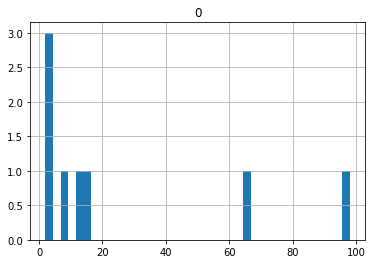

In [123]:
cluster_stat(telnet_big_dict,telnet_df)

In [125]:
write2pkl(telnet_df,telnet_big_dict,170578,"telnet_1")
write2pkl(telnet_df,telnet_big_dict,336613,"telnet_2")
write2pkl(telnet_df,telnet_big_dict,6089291,"telnet_3")


Unique Country#: 1 Unique IP#: 10 Session#: 98
Unique Country#: 2 Unique IP#: 4 Session#: 65
Unique Country#: 2 Unique IP#: 5 Session#: 14


In [302]:
telnet_df[telnet_df.ip_src == '184.154.47.2']

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
4323967,1.578657e+09,"[1578656838.646141, 1578656838.646389, 1578656...",15.580751,14,9,5,1543,1170.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,607.0,580.0,27.0,64.444444,5.40,184.154.47.2,210.242.148.22,60274.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[6:KvVhWKnfANAIKIZVyfOMDiZce5C/jcwV1OkYVoMRo5...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157865..."
6089291,1.578657e+09,"[1578656859.986416, 1578656859.986725, 1578656...",10.429977,9,5,4,784,485.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.0,159.0,27.0,31.800000,6.75,184.154.47.2,210.242.148.22,34096.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:YnT4FLBIhvcKC/gkyVF9ekV9A05fxquQCh+nYM:sT...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157865..."
6592952,1.578636e+09,"[1578636262.320167, 1578636263.319424, 1578636...",17.556145,15,10,5,1853,1480.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,843.0,816.0,27.0,81.600000,5.40,184.154.47.2,210.242.148.18,53990.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:rHXq6xmMRe48Is0+R56Y1awh5UP+/4D7eiMJNkZr1...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157863..."
8863854,1.578657e+09,"[1578656831.159723, 1578656832.15703, 15786568...",14.985957,15,10,5,1853,1480.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,843.0,816.0,27.0,81.600000,5.40,184.154.47.2,210.242.148.22,50922.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:rHXq6xmMRetkIs0+R56Y1awh5UP+/4D7eiMJNkZr1...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157865..."
9116585,1.578646e+09,"[1578645820.728886, 1578645821.727919, 1578645...",16.753340,11,7,4,1055,756.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317.0,290.0,27.0,41.428571,6.75,184.154.47.2,210.242.149.17,43548.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:Ynf852ccEKC/gkOkOoMReT2VmF9eqSz0uP4:wccEX...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157864..."
22241687,1.578646e+09,"[1578645813.079108, 1578645813.079411, 1578645...",15.845175,9,5,4,829,530.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231.0,204.0,27.0,40.800000,6.75,184.154.47.2,210.242.149.17,34296.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:rHXq6xmMReT2klIs0+R56Y1awh5UP+/4D7eiMJNkZ...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157864..."
30568753,1.578636e+09,"[1578636288.475206, 1578636288.475441, 1578636...",12.050930,9,5,4,784,485.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.0,159.0,27.0,31.800000,6.75,184.154.47.2,210.242.148.18,49816.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tc

In [303]:
find_cluster(telnet_big_dict,43187420)

32297542

In [305]:
write2pkl(telnet_df,telnet_big_dict,32297542,3)

2 2


#### tds

In [89]:
tds_df, tds_df_payload = prepare_df(df2,'tds')
tds_big_dict = similarity_compare(tds_df,tds_df_payload)
len(tds_big_dict.keys()) #10:03:06

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

29

原本總共sessions#: 2225820
共有#sessions可分群: 2225816 共有#lonerSessions: 4
可分為#群: 29
前三大的cluster key與對應之群集大小
 263     1408535
810      168175
2901     158220
Name: 0, dtype: int64
                  0
count  2.900000e+01
mean   7.675228e+04
std    2.618884e+05
min    2.000000e+00
25%    1.200000e+01
50%    1.520000e+02
75%    1.459300e+04
max    1.408535e+06


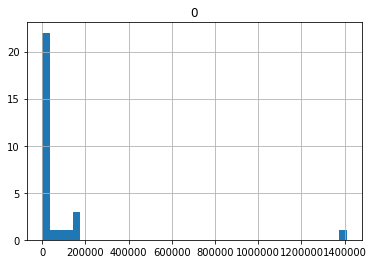

In [126]:
cluster_stat(tds_big_dict,tds_df)

In [127]:
write2pkl(tds_df,tds_big_dict,263,"tds_1")
write2pkl(tds_df,tds_big_dict,810,"tds_2")
write2pkl(tds_df,tds_big_dict,2901,"tds_3")


Unique Country#: 56 Unique IP#: 400 Session#: 1408535
Unique Country#: 78 Unique IP#: 924 Session#: 168175
Unique Country#: 53 Unique IP#: 375 Session#: 158220


In [316]:
tds_df[tds_df.ip_src == '116.98.142.146']

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
8880,1.578652e+09,"[1578652258.789153, 1578652258.7894, 157865225...",1.208934,8,5,3,732,478.0,254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,196.0,74.0,39.200000,24.666667,116.98.142.146,210.242.145.125,39341.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:M5YxTvuw3zLw7Ve9VgfY1QWxQtTVGgZA+Oi56imXJ...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
8893,1.578651e+09,"[1578650551.93434, 1578650551.934552, 15786505...",0.576697,8,5,3,730,476.0,254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,268.0,194.0,74.0,38.800000,24.666667,116.98.142.146,210.242.145.65,33691.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:MdjYxTvuw3zLoyDV33uuEftajiA+Oi56iEvXJ:MC9...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
8950,1.578648e+09,"[1578647726.148316, 1578647726.148473, 1578647...",1.452684,10,6,4,924,542.0,382.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342.0,194.0,148.0,32.333333,37.000000,116.98.142.146,210.242.145.65,47653.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:MdjYxTvuw3zLoy7xVZABVZeLpCZpCZp9sAPt3ppA+...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
8956,1.578651e+09,"[1578651049.900827, 1578651049.901286, 1578651...",93.001999,14,8,6,1280,840.0,440.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,458.0,384.0,74.0,48.000000,12.333333,116.98.142.146,210.242.145.65,48028.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:M4YxTvuw36GmRpTuKZpVZAaE3YpyoyVfpA+Oi56iE...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
8959,1.578648e+09,"[1578647865.141733, 1578647865.142038, 1578647...",0.592815,10,6,4,922,540.0,382.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,340.0,192.0,148.0,32.000000,37.000000,116.98.142.146,210.242.145.65,48704.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:M4YxTvuw36GmRpJinvhtIJ1VNVQA+Oi56iEvXJ:M9...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50218448,1.578653e+09,"[1578652838.658343, 1578652838.658545, 1578652...",0.670841,8,5,3,724,476.0,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,268.0,194.0,74.0,38.800000,24.666667,116.98.142.146,210.242.149.123,49321.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:MdjYxTvuw36I2OTApieK5xCVtpA+Oi5ac8VlJ:MC9...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
50218459,1.578653e+09,"[1578652571.62375, 1578652571.623942, 15786525...",149.046448,22,11,11,19

In [317]:
key_ = find_cluster(tds_big_dict,50218448)
write2pkl(tds_df,tds_big_dict,key_,4)

Unique Country#: 35 Unique IP#: 177 Session#: 1335894


#### smtp

In [133]:
smtp_df, smtp_df_payload = prepare_df(df2,'smtp')
smtp_big_dict = similarity_compare(smtp_df,smtp_df_payload)
len(smtp_big_dict.keys()) #10:03:06

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

30

原本總共sessions#: 14256
共有#sessions可分群: 14232 共有#lonerSessions: 24
可分為#群: 30
前三大的cluster key與對應之群集大小
 28053    11671
73899      735
4033       594
Name: 0, dtype: int64
                  0
count     30.000000
mean     474.400000
std     2121.915215
min        2.000000
25%        8.000000
50%       12.500000
75%       64.750000
max    11671.000000


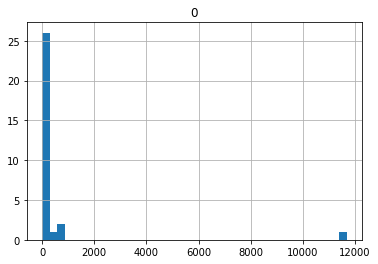

In [134]:
cluster_stat(smtp_big_dict,smtp_df)

In [135]:
write2pkl(smtp_df,smtp_big_dict,28053,"smtp_1")
write2pkl(smtp_df,smtp_big_dict,73899,"smtp_2")
write2pkl(smtp_df,smtp_big_dict,4033,"smtp_3")


Unique Country#: 7 Unique IP#: 21 Session#: 11671
Unique Country#: 3 Unique IP#: 11 Session#: 735
Unique Country#: 8 Unique IP#: 31 Session#: 594


#### FTP

In [136]:
ftp_df, ftp_df_payload = prepare_df(df2,'ftp')
ftp_big_dict = similarity_compare(ftp_df,ftp_df_payload)
len(ftp_big_dict.keys()) #10:03:06

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

27

原本總共sessions#: 7675
共有#sessions可分群: 7669 共有#lonerSessions: 6
可分為#群: 27
前三大的cluster key與對應之群集大小
 2001     5504
3479      855
83203     324
Name: 0, dtype: int64
                 0
count    27.000000
mean    284.037037
std    1057.745806
min       2.000000
25%       8.000000
50%      28.000000
75%      56.000000
max    5504.000000


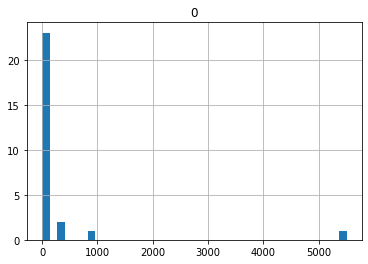

In [137]:
cluster_stat(ftp_big_dict,ftp_df)

In [138]:
write2pkl(ftp_df,ftp_big_dict,2001,"ftp_1")
write2pkl(ftp_df,ftp_big_dict,3479,"ftp_2")
write2pkl(ftp_df,ftp_big_dict,83203,"ftp_3")


Unique Country#: 9 Unique IP#: 42 Session#: 5504
Unique Country#: 7 Unique IP#: 143 Session#: 855
Unique Country#: 3 Unique IP#: 5 Session#: 324


### sip

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

原本總共sessions#: 5173
共有#sessions可分群: 5171 共有#lonerSessions: 2
可分為#群: 4
前三大的cluster key與對應之群集大小
 168648    4738
27198      280
268847     139
Name: 0, dtype: int64
                 0
count     4.000000
mean   1292.750000
std    2299.402151
min      14.000000
25%     107.750000
50%     209.500000
75%    1394.500000
max    4738.000000


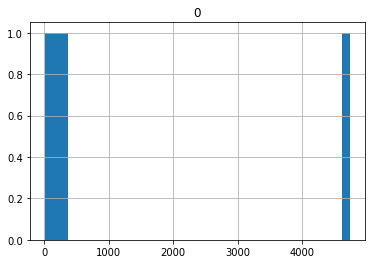

In [139]:
sip_df, sip_df_payload = prepare_df(df2,'sip')
sip_big_dict = similarity_compare(sip_df,sip_df_payload)
cluster_stat(sip_big_dict,sip_df)

In [140]:
write2pkl(sip_df,sip_big_dict,168648,"sip_1")
write2pkl(sip_df,sip_big_dict,27198,"sip_2")
write2pkl(sip_df,sip_big_dict,268847,"sip_3")


Unique Country#: 1 Unique IP#: 1 Session#: 4738
Unique Country#: 2 Unique IP#: 49 Session#: 280
Unique Country#: 1 Unique IP#: 2 Session#: 139


#### Mysql

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

原本總共sessions#: 1033
共有#sessions可分群: 621 共有#lonerSessions: 412
可分為#群: 6
前三大的cluster key與對應之群集大小
 83156       413
11939584     67
1725770      55
43979315     53
26070610     22
Name: 0, dtype: int64
                0
count    6.000000
mean   103.500000
std    153.116622
min     11.000000
25%     29.750000
50%     54.000000
75%     64.000000
max    413.000000


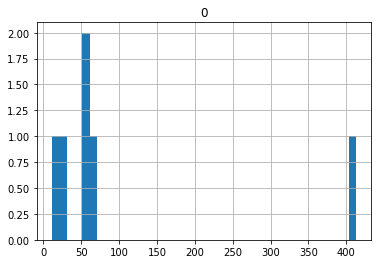

In [61]:
mysql_df, mysql_df_payload = prepare_df(df2,'mysql',split='size')
mysql_big_dict,mysql_loner,mysql_score = similarity_compare(mysql_df,mysql_df_payload,thr=80)
cluster_stat(mysql_big_dict,mysql_df)

                  0
count  24096.000000
mean      16.012568
std       20.456599
min        0.000000
25%        0.000000
50%        0.000000
75%       33.333333
max      100.000000


Counter({0.0: 12865,
         33.333333333333336: 6941,
         5.333333333333333: 430,
         26.333333333333332: 129,
         26.0: 82,
         12.666666666666666: 36,
         17.333333333333332: 65,
         25.0: 29,
         19.333333333333332: 67,
         25.666666666666668: 98,
         26.666666666666668: 93,
         27.333333333333332: 38,
         18.0: 39,
         19.0: 59,
         24.666666666666668: 38,
         16.0: 12,
         16.666666666666668: 11,
         11.0: 3,
         100.0: 474,
         27.0: 147,
         32.0: 412,
         29.0: 280,
         30.0: 1,
         45.0: 4,
         21.333333333333332: 571,
         8.333333333333334: 53,
         18.333333333333332: 73,
         20.666666666666668: 2,
         20.0: 30,
         16.333333333333332: 15,
         21.666666666666668: 4,
         18.666666666666668: 1,
         23.666666666666668: 1,
         22.0: 2,
         24.5: 22,
         27.5: 87,
         50.0: 367,
         28.5: 21,
         

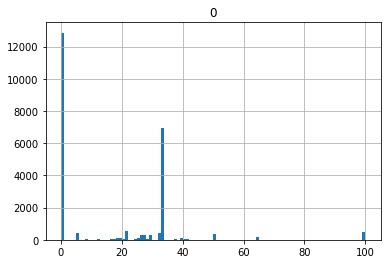

In [60]:
temp = pd.DataFrame(mysql_score)
temp.hist(bins=100)
print(temp.describe())
Counter(mysql_score)

In [62]:
write2pkl(mysql_df,mysql_big_dict,83156,"mysql_1")
write2pkl(mysql_df,mysql_big_dict,11939584,"mysql_2")
write2pkl(mysql_df,mysql_big_dict,1725770,"mysql_3")


Unique Country#: 3 Unique IP#: 3 Session#: 413
Unique Country#: 1 Unique IP#: 1 Session#: 67
Unique Country#: 1 Unique IP#: 1 Session#: 55


In [143]:
pickle.dump(obj=(http_big_dict,smb_big_dict,telnet_big_dict,tds_big_dict,smtp_big_dict,ftp_big_dict,
                 sip_big_dict,mysql_big_dict),file=open(pickle_dir+"allProtocol_case_dict.pkl",'wb'))

# Deprecated
* old original function

In [69]:
def build_matrix(sessions_payload,idxes):
    '''
    sessions_payload: list of lists (hashes)
    idxes: list (corresponding Index)
    
    Return: dictionry=> key=idx,value=list of tuples (idx_compare,final_session_score)
    '''
    sessions_num = len(sessions_payload)
    assert  sessions_num == len(idxes)
    big_dict = {}
    all_scores = []
    for i,(packets_payload,idx) in tqdm(enumerate(zip(sessions_payload,idxes))):
        packets_num = len(packets_payload)
        q1 = int(packets_num/4)
        q2 = int(packets_num/2)
        q3 = int(packets_num*0.75)
        
        tryq1 = packets_payload[q1]
        tryq1_split = tryq1.split(':')
        q1len_segment = tryq1_split[0]
        q1len_payload = ":".join(tryq1_split[1:])        
        if q1 == q2 == q3:
            flag=False
        else:
            tryq2 = packets_payload[q2]
            tryq2_split = tryq2.split(':')
            q2len_segment = tryq2_split[0]
            q2len_payload = ":".join(tryq2_split[1:])
            
            tryq3 = packets_payload[q3]
            tryq3_split = tryq3.split(':')
            q3len_segment = tryq3_split[0]
            q3len_payload = ":".join(tryq3_split[1:])            
            flag = True

        final_li = []
        for j in range(sessions_num-i-1): #往下比
            idx_compare = j+i+1
            session_payload_compare = sessions_payload[idx_compare]
            session_score = []
            for packet_payload_compare in session_payload_compare: #packet_payload_compare == '6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHXq6xmMRe9SNYV3NkZr8m'                
                test_segment = packet_payload_compare.split(':')[0]
                if test_segment == q1len_segment:
                    scoreq1 = ssdeep.compare(tryq1,packet_payload_compare)
                else:
                    scoreq1 = 0
                if flag:
                    if test_segment == q2len_segment:
                        scoreq2 = ssdeep.compare(tryq2,packet_payload_compare)
                    else:
                        scoreq2 = 0
                    if test_segment == q3len_segment:
                        scoreq3 = ssdeep.compare(tryq3,packet_payload_compare)
                    else:
                        scoreq3 = 0
                    if scoreq1 == scoreq2 == scoreq3 <1:
                        min_packet = packets_payload[0]
                        max_packet = packets_payload[-1]
                        scoreMin = 0
                        scoreMax = 0
                        if min_packet.split(':')[0] == test_segment:
                            scoreMin = ssdeep.compare(min_packet,packet_payload_compare) #第一個時間得比較
                        if max_packet.split(':')[0] == test_segment:
                            scoreMax = ssdeep.compare(max_packet,packet_payload_compare) #最後一個時間得比較
                        session_score.append(max(scoreMin,scoreMax))
                        continue
                session_score.append(max(scoreq1,scoreq2,scoreq3))
            final_score = max(session_score)
            if final_score>0:
                final_li.append((idxes[idx_compare],final_score))
                all_scores.append(final_score) #統計用
        big_dict[idx] = final_li
    return big_dict,all_scores
#                 test_split = packet_payload_compare.split(':')
#                 test_segment = test_split[0]
#                 if 

In [93]:
%%time
def build_matrix_mu(sessions_payload,idxes):
    '''
    sessions_payload: list of lists (hashes)
    idxes: list (corresponding Index)
    
    Return: dictionry=> key=idx,value=list of tuples (idx_compare,final_session_score)
    '''
    sessions_num = len(sessions_payload)
    assert  sessions_num == len(idxes)
    inputs = [(i,x,y) for i,(x,y) in enumerate(zip(sessions_payload,idxes))]
    
    
#     all_scores = []
def func(param):#i,(packets_payload,idx) in tqdm(enumerate(zip(sessions_payload,idxes))):
    i,packets_payload,idx = param
    big_dict = {}
    packets_num = len(packets_payload)
    q1 = int(packets_num/4)
    q2 = int(packets_num/2)
    q3 = int(packets_num*0.75)

    tryq1 = packets_payload[q1]
    tryq1_split = tryq1.split(':')
    q1len_segment = tryq1_split[0]
    q1len_payload = ":".join(tryq1_split[1:])        
    if q1 == q2 == q3:
        flag=False
    else:
        tryq2 = packets_payload[q2]
        tryq2_split = tryq2.split(':')
        q2len_segment = tryq2_split[0]
        q2len_payload = ":".join(tryq2_split[1:])

        tryq3 = packets_payload[q3]
        tryq3_split = tryq3.split(':')
        q3len_segment = tryq3_split[0]
        q3len_payload = ":".join(tryq3_split[1:])            
        flag = True

    final_li = []
    for j in range(sessions_num-i-1): #往下比
        idx_compare = j+i+1
        session_payload_compare = sessions_payload[idx_compare]
        session_score = []
        for packet_payload_compare in session_payload_compare: #packet_payload_compare == '6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHXq6xmMRe9SNYV3NkZr8m'                
            test_segment = packet_payload_compare.split(':')[0]
            scoreq1 = scoreq2 = scoreq3 = 0
            if test_segment == q1len_segment:
                scoreq1 = ssdeep.compare(tryq1,packet_payload_compare)
#             else:
#                 scoreq1 = 0
            if flag:
#                 scoreq2 = 0
                if test_segment == q2len_segment:
                    scoreq2 = ssdeep.compare(tryq2,packet_payload_compare)
#                 else:
#                     scoreq2 = 0
#                 scoreq3 = 0
                if test_segment == q3len_segment:
                    scoreq3 = ssdeep.compare(tryq3,packet_payload_compare)
#                 else:
#                     scoreq3 = 0
                if scoreq1 == scoreq2 == scoreq3 <1:
                    min_packet = packets_payload[0]
                    max_packet = packets_payload[-1]
                    scoreMin = scoreMax = 0
#                     scoreMax = 0
                    if min_packet.split(':')[0] == test_segment:
                        scoreMin = ssdeep.compare(min_packet,packet_payload_compare) #第一個時間得比較
                    if max_packet.split(':')[0] == test_segment:
                        scoreMax = ssdeep.compare(max_packet,packet_payload_compare) #最後一個時間得比較
                    session_score.append(max(scoreMin,scoreMax))
                    continue
            session_score.append(max(scoreq1,scoreq2,scoreq3))
        final_score = max(session_score)
        if final_score>0:
            final_li.append((idxes[idx_compare],final_score))
#             all_scores.append(final_score) #統計用
    big_dict[idx] = final_li

#         pool = Pool()
inputs = [(i,x,y) for i,(x,y) in enumerate(zip(session_payload,df2_http.index))]
sessions_num = len(session_payload)
sessions_payload=session_payload
idxes = df2_http.index
pool = Pool()
start = time.time()
out_li = pool.map(func,inputs)
end = time.time()
# with mp.Manager() as manager:
#     big_dict = manager.dict()
#     with manager.Pool() as pool:
#         pool.map(func, inputs) #(sessions_num,i,sessions_payload,q1len_segment,tryq1,q2len_segment,tryq2,q3len_segment,
            #tryq3,packets_payload)
#     return big_dict#,all_scores

#5h 33min 29s

CPU times: user 17.3 s, sys: 19 s, total: 36.4 s
Wall time: 5h 33min 29s


Process ForkPoolWorker-45:
Process ForkPoolWorker-46:
Process ForkPoolWorker-43:
Process ForkPoolWorker-38:
Process ForkPoolWorker-37:
Process ForkPoolWorker-47:
Process ForkPoolWorker-42:
Process ForkPoolWorker-39:
Process ForkPoolWorker-44:
Process ForkPoolWorker-40:
Process ForkPoolWorker-41:
Process ForkPoolWorker-36:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [109]:

def similarity_compare_mu(df2_protocol,df2_protocol_payload,thr=40,nprocs=12):
    '''
    GOAL: Multi-preocessing a function.
    df2_protocol: protocol original dataframe (session-based)
    df2_protocol_payload: protocol payload dataframe (packet-based)
    
    Return: dictionary with each cluster 
    '''
    def ssdeep_compare(target_hash,candidate_df):
        '''
        Input1: string of hash
        Input2: dataframe of candidate
        '''
        def compare(candidate_hash):
            return ssdeep.compare(target_hash,candidate_hash)
        return candidate_df.hash.map(compare)
#     big_dict_protocol = {}
#     for idx in tqdm(df2_protocol.index):
#         if idx in used_idx_li:
#             continue
        
    def main_compare(idx,out_q):
        big_dict_protocol = {}
        target = df2_protocol_payload[df2_protocol_payload.idx == idx]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q1 = int(t_len*0.25)
        q2 = int(t_len*0.5)
        t_q1 = target.iloc[q1,-1]
        candidate = df2_protocol_payload[df2_protocol_payload.idx>idx]
        candidate['idx'] = candidate.idx.astype(str)
        candidate_q1 = candidate[candidate['size']==target.iloc[q1,-2]]
        candidate['q1'] = ssdeep_compare(t_q1,candidate_q1)
        if q2 != q1:
            t_q2 = target.iloc[q2,-1]
            q3 = int(t_len*0.75)
            candidate_q2 = candidate[candidate['size']==target.iloc[q2,-2]]
            candidate['q2'] = ssdeep_compare(t_q2,candidate_q2)
            if q3 != q2:
                t_q3 = target.iloc[q3,-1]
                candidate_q3 = candidate[candidate['size']==target.iloc[q3,-2]]
                candidate['q3'] = ssdeep_compare(t_q3,candidate_q3)
        candidate = candidate.drop(['size','hash'],axis=1)
        candidate['score'] = candidate.max(axis=1)
        candidate = candidate[candidate.score>=thr] #相似度分數，數字越小速度愈快、數字越大越多群
        candidate['idx'] = candidate.idx.astype(int)
        idx_li = candidate.idx.tolist()
        if len(idx_li)>0:
            big_dict_protocol[idx] = idx_li
#             used_idx_li.extend(idx_li)
#             used_idx_li = list(set(used_idx_li))
        out_q.put(big_dict_protocol)#return big_dict_protocol
#     with Manager() as manager:
#     used_idx_li = manager.list()
    out_q = mp.Queue()
    
#         big_dict_protocol = manager.dict()
    procs = []
    idx_li = df2_protocol.index.tolist()
    chunksize = int(math.ceil(len(idx_li) / float(nprocs)))
#     for idx in df2_protocol.index:
        
    for i in range(nprocs):
        p = mp.Process(target=main_compare,args=(idx_li[chunksize*i:chunksize*(i+1)],out_q))
        procs.append(p)
        p.start()
#     for idx in tqdm(df2_protocol.index):
#         if idx in used_idx_li:
#             continue
#         p = Process(target=main_compare, args=(used_idx_li,idx,big_dict_protocol))
#         p.start()
#         time.sleep(0.5)
#         processes.append(p)
    resultdict = {}    
    for i in range(nprocs):
        resultdict.update(out_q.get())
    for p in procs:
#         time.sleep(0.5)
        p.join()
    return resultdict#big_dict_protocol